In [1]:
import numpy as np
import pandas as pd
import uproot
import xgboost as xgb
import matplotlib.pyplot as plt
from xgbo import XgboRegressor
import os
from scipy.stats import norm
import matplotlib.mlab as mlab
import iminuit
import probfit
import probfit.pdf
import sklearn as sk
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
def load_data(file_name, entrystop, isEE=False):

    root_file = uproot.open(file_name)

    # The branches we need for the regression
    branches_EB = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5',
            'iPhiMod2', 'iEtaMod20', 'iPhiMod20', 'genEnergy']

    branches_EE = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi',
            'genEnergy', 'iXSeed', 'iYSeed', 'preshowerEnergy']

    if isEE:
        branches = branches_EE + ["pt", "eta"]
    else:
        branches = branches_EB + ["pt", "eta"]

    if "Electron" in file_name:
        df = root_file['een_analyzer/ElectronTree'].pandas.df(branches, entrystop=entrystop).dropna()
    if "Photon" in file_name:
        df = root_file['een_analyzer/PhotonTree'].pandas.df(branches, entrystop=entrystop).dropna()
    print("Entries in ntuple:")
    print(len(df))
    print(df.shape)


    df.eval("clusertRawEnergyOverE5x5 = clusterRawEnergy/full5x5_e5x5", inplace=True)
    df.eval("w3x3OverE5x5             = full5x5_e3x3/full5x5_e5x5", inplace=True)
    df.eval("eMaxOverE5x5             = full5x5_eMax/full5x5_e5x5", inplace=True)
    df.eval("e2ndOverE5x5             = full5x5_e2nd/full5x5_e5x5", inplace=True)
    df.eval("eTopOverE5x5             = full5x5_eTop/full5x5_e5x5", inplace=True)
    df.eval("eBottomOverE5x5          = full5x5_eBottom/full5x5_e5x5", inplace=True)
    df.eval("eLeftOverE5x5            = full5x5_eLeft/full5x5_e5x5", inplace=True)
    df.eval("eRightOverE5x5           = full5x5_eRight/full5x5_e5x5", inplace=True)
    df.eval("e2x5MaxOverE5x5          = full5x5_e2x5Max/full5x5_e5x5", inplace=True)
    df.eval("e2x5TopOverE5x5          = full5x5_e2x5Top/full5x5_e5x5", inplace=True)
    df.eval("e2x5BottomOverE5x5       = full5x5_e2x5Bottom/full5x5_e5x5", inplace=True)
    df.eval("e2x5LeftOverE5x5         = full5x5_e2x5Left/full5x5_e5x5", inplace=True)
    df.eval("e2x5RightOverE5x5        = full5x5_e2x5Right/full5x5_e5x5", inplace=True)

    if isEE:
        df.eval("preshowerEnergyOverrawEnergy = preshowerEnergy/rawEnergy", inplace=True)

    # The target
    if isEE:
        df.eval("target = genEnergy / ( rawEnergy + preshowerEnergy )", inplace=True)
    else:
        df.eval("target = genEnergy / rawEnergy", inplace=True)

    return df


In [28]:
# The features
features_EB = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5', 'iPhiMod2',
        'iEtaMod20', 'iPhiMod20','pt','eta','target']

# EE
features_EE = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iXSeed', 'iYSeed', 'preshowerEnergyOverrawEnergy','pt','eta','target']


file_name = "/scratch/micheli/Electron/perfectIC-lowpt-EB-training.root"


isEE = '-EE-' in file_name

if isEE:
    features = features_EE
else:
    features = features_EB
DF= load_data(file_name, entrystop=500000,isEE=isEE)


Entries in ntuple:
1145341
(1145341, 30)


In [29]:

DF=DF.query('pt>20')

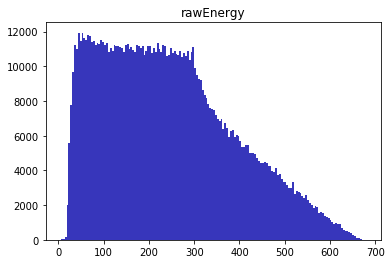

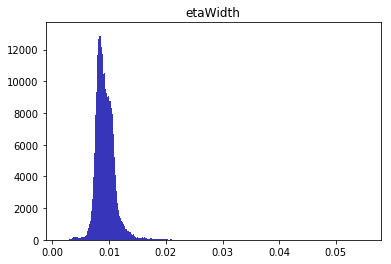

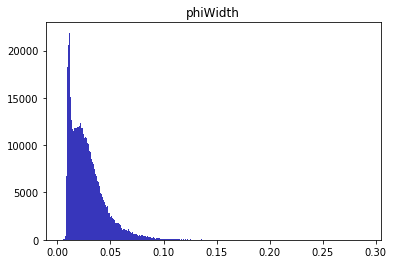

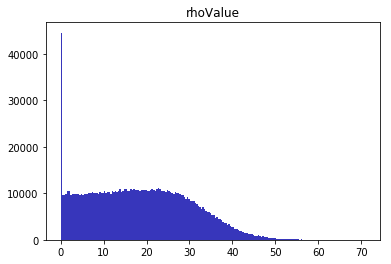

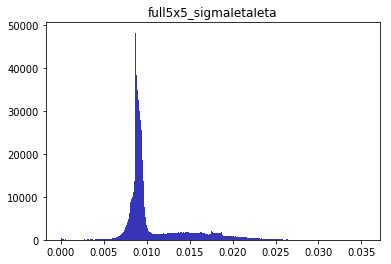

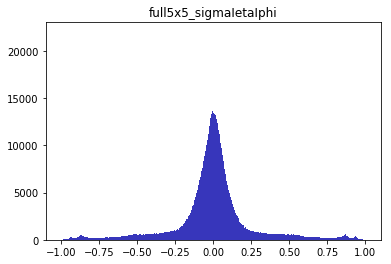

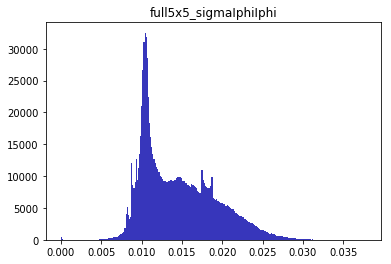

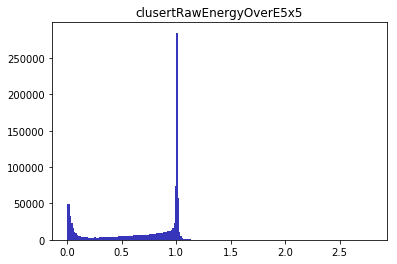

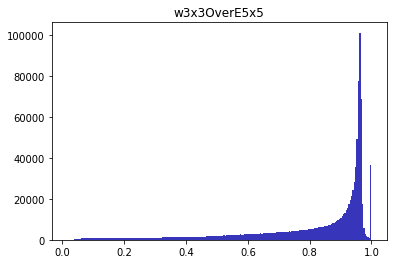

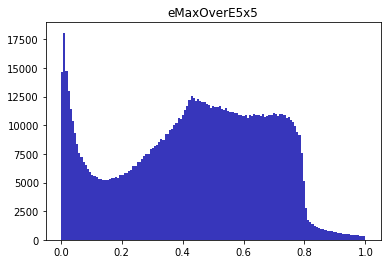

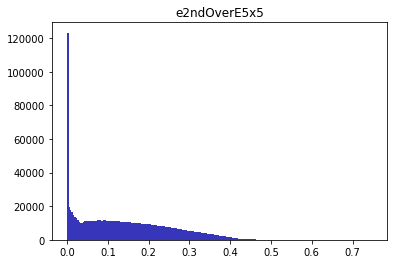

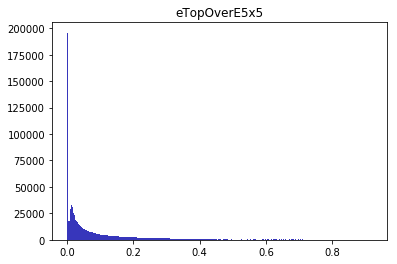

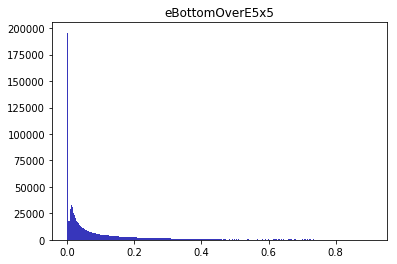

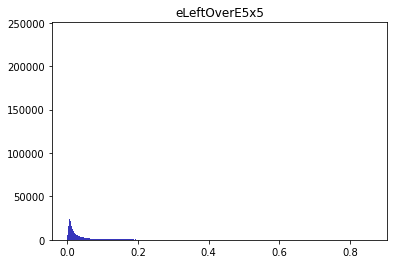

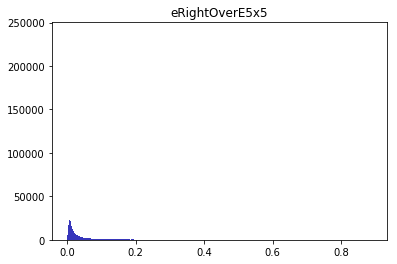

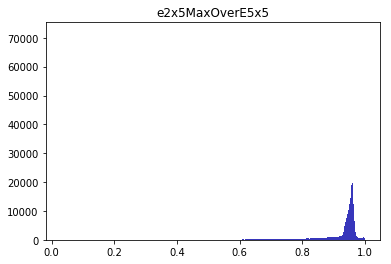

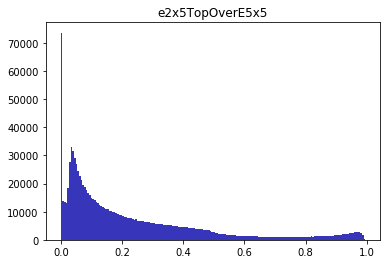

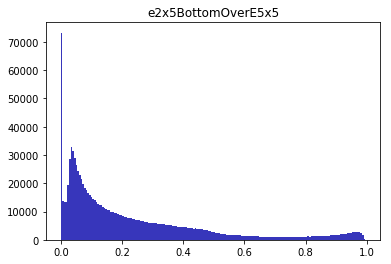

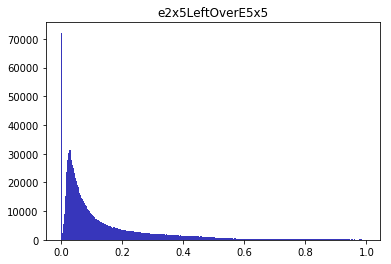

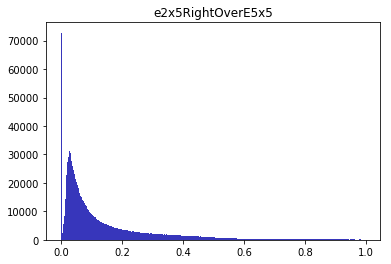

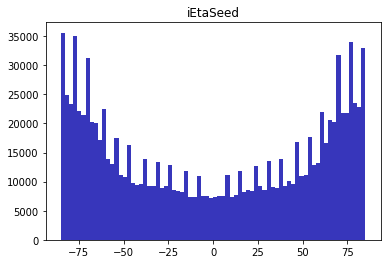

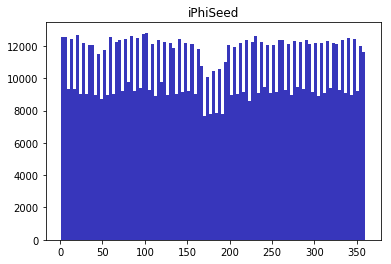

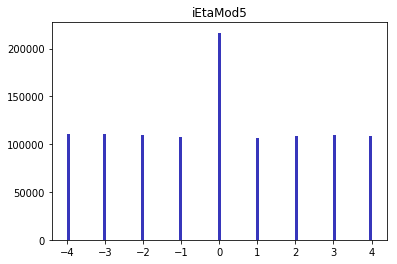

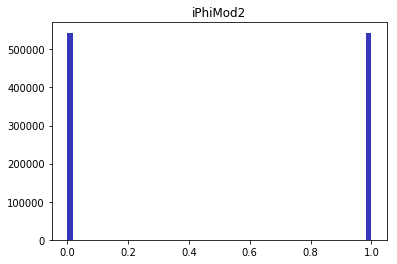

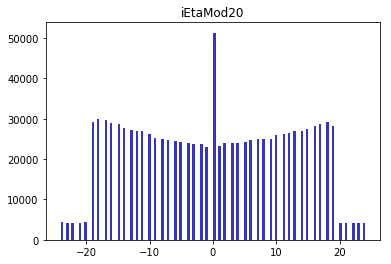

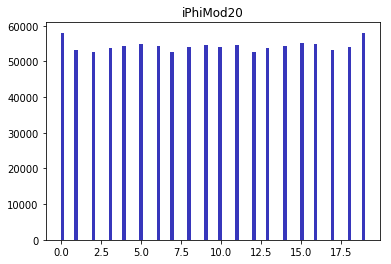

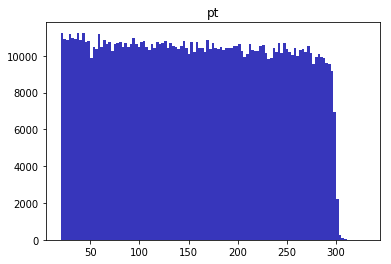

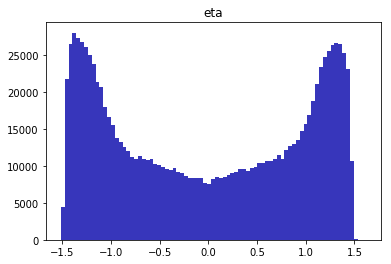

In [5]:
for para in features:
    #(mu, sigma) = norm.fit(DF[para])
    if para =='target':
        pass
    else:
        weights = np.ones_like(DF[para])/float(len(DF[para]))
        n, bins, patches = plt.hist(x=DF[para], bins='auto',weights=None,alpha=0.8, color='#0504aa',density=0)
        plt.title(para)
        #plt.xlabel('Value')
        #plt.ylabel('Frequency')
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=2)
        plt.savefig(para+'.png')

        plt.show()
    

<function matplotlib.pyplot.show>

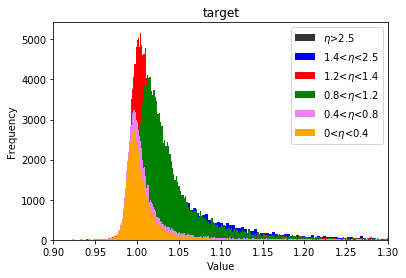

In [6]:
DF_endcap=DF.query('eta>2.5')
DF_endbarrell=DF.query('1.2<eta<1.4')
DF1=DF.query('0.8<eta<1.2')
DF0=DF.query('0.4<eta<0.8')
DF2=DF.query('0<eta<0.4')
DF3=DF.query('1.4<eta<2.5')
DF4=DF.query('eta<0')
plt.figure()
plt.title('target')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.hist(DF_endcap['target'],bins='auto',alpha=0.8,color='black',density=0,label='$\eta$>2.5')
plt.hist(DF3['target'],bins='auto',color='blue',label='1.4<$\eta$<2.5')
plt.hist(DF1['target'],bins='auto',color='red',label='1.2<$\eta$<1.4')
plt.hist(DF_endbarrell['target'],bins='auto',color='green',label='0.8<$\eta$<1.2')
plt.hist(DF0['target'],bins='auto',color='violet',label='0.4<$\eta$<0.8')

plt.hist(DF2['target'],bins='auto',color='orange',label='0<$\eta$<0.4')
#plt.hist(DF4['target'],bins='auto',color='yellow',label='$\eta$<0')
#plt.ylim([0,50])
plt.xlim([0.9,1.3])
plt.savefig('target.png')
plt.legend()
plt.show

eta>2.5
2<eta<2.5
1.2<eta<1.4
0.8<eta<1.2
0.4<eta<0.8
0<eta<0.4
eta<0


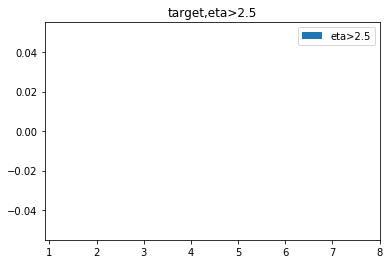

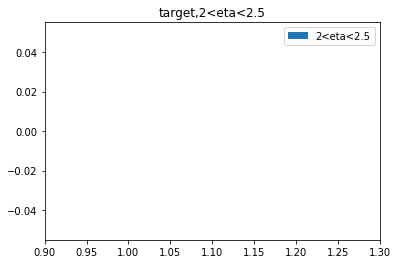

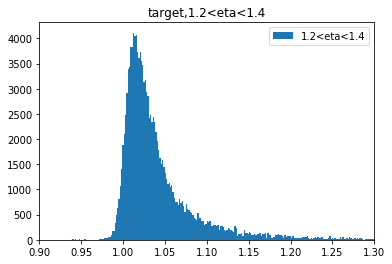

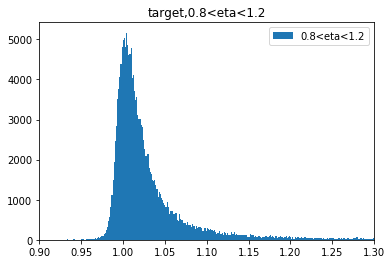

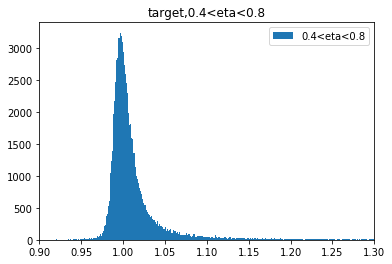

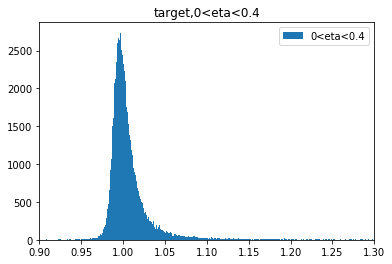

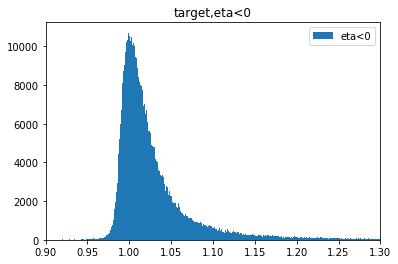

In [7]:
feat_etabin=['eta>2.5','2<eta<2.5','1.2<eta<1.4','0.8<eta<1.2','0.4<eta<0.8','0<eta<0.4','eta<0']
i=0
#DF_etabin=pd.DataFrame(data=[DF.query('eta>2.5'),DF.query('1.4<eta<2.5'),DF.query('1.2<eta<1.4'),DF.query('0.8<eta<1.2'),DF.query('0.4<eta<0.8'),DF.query('0<eta<0.4')],columns=[feat_etabin])
for para in feat_etabin:
    if i==0:
        j=8
    else:
        j=1.3
    print(para)
    plt.figure()
    df=DF.query(para)
    plt.hist(df['target'],bins='auto',label=para)
    #plt.ylim([0,500])
    plt.title('target,'+para)
    plt.xlim([0.9,j])
    plt.savefig('target_'+para+'.png')
    plt.legend()
    plt.show
    i+=1

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:33: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:33: SmallIntegralWarning: (-0.5, 0.01, 12.0, 3.8, 1.0, -0.7642479606310687)


FCN = 16174.3255167 
 TOTAL NCALL = 516 
 NCALLS = 516 
 
 
 EDM = 1.54048077771e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,-0.0702198,0.00661285,,,,,No
1,alpha2,0.0134904,0.00126925,,,,,No
2,n,12.9564,0.293534,,,,,No
3,n2,6.7734,0.0432268,,,,,No
4,mean,0.99513,2.14283e-05,,,,,No
5,sigma,0.000375032,3.52765e-05,,,,,No


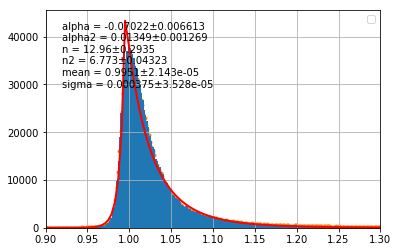

<Figure size 432x288 with 0 Axes>

In [30]:
rmin = 0.8
rmax = 1.6
nbins = 100

data=np.array(DF.query('target<1.3')['target']).astype('double')
plt.figure()
plt.hist(data,bins=500)
plt.xlim([0.9,1.3])
#plt.show()
# Fit a DCB
bound_DCB=[rmin, rmax]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood   = probfit.BinnedLH(normalized_DCB, data, bins=500, bound=bound_DCB)

#best_try = probfit.try_uml(binned_likelihood, data, alpha=0.1,alpha2=0.3, n=2.1,n2=5, mean=1.2, sigma=0.03)
#print(best_try)
pars_dcb = dict(mean  = 1., 
                fix_mean = False,
                sigma  = 0.002,
                fix_sigma = False,
                alpha  = -0.5,
                fix_alpha = False,
                n      = 12.0,
                fix_n  = False,
                alpha2 = 0.01,
                fix_alpha2 = False,
                n2     = 3.8,
                fix_n2  = False
                )


minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
minuit.migrad()

binned_likelihood.draw(minuit)
plt.legend(loc='upper right')
plt.show()
plt.savefig('target_all_eta_fit'+'.png')
print(minuit)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
27.80284525553393


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.10742928941544343)


FCN = 316.32253498 
 TOTAL NCALL = 521 
 NCALLS = 521 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,11.8505,nan,,,,,No
1,alpha2,0.343707,nan,,,,,No
2,n,39.0004,nan,,,,,No
3,n2,6.00352,nan,,,,,No
4,mean,1.0171,nan,,,,,No
5,sigma,0.0098452,nan,,,,,No


FCN = 316.322505864 
 TOTAL NCALL = 124 
 NCALLS = 124 
 
 
 EDM = 1.1161333864e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,17.996,0.199838,,,,,No
1,alpha2,0.343616,0.0132282,,,,,No
2,n,100.456,0.974961,,,,,No
3,n2,6.009,0.745063,,,,,No
4,mean,1.0171,0.000266332,,,,,No
5,sigma,0.00984474,0.000160615,,,,,No


1.4<eta<1.6


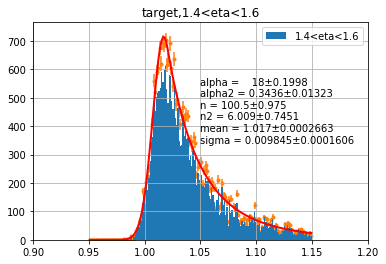

162.7568125279743


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.22237778773363623)


FCN = 686.193913301 
 TOTAL NCALL = 420 
 NCALLS = 409 
 
 
 EDM = 172781.799168 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,5.87378,0.708387,,,,,No
1,alpha2,0.491926,0.708392,,,,,No
2,n,66.747,0.707107,,,,,No
3,n2,3.36084,0.708386,,,,,No
4,mean,1.01518,0.70838,,,,,No
5,sigma,0.0112075,0.70838,,,,,No


FCN = 600.996505467 
 TOTAL NCALL = 161 
 NCALLS = 161 
 
 
 EDM = 1.81422647051e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.51276,0.0597648,,,,,No
1,alpha2,0.491926,1,,,,,Yes
2,n,66.747,1,,,,,Yes
3,n2,3.68786,0.0657431,,,,,No
4,mean,1.0156,7.46622e-05,,,,,No
5,sigma,0.0113817,5.66067e-05,,,,,No


1.2<eta<1.4


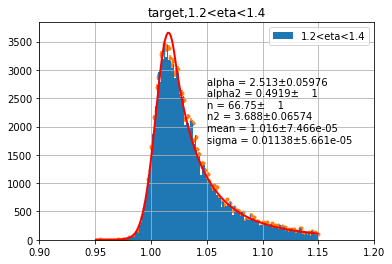

124.3074495426814


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.15462551680117675)


FCN = 545.620981383 
 TOTAL NCALL = 527 
 NCALLS = 527 
 
 
 EDM = 1.85635233158e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,5.20883,1.41421,,,,,No
1,alpha2,0.482808,0.00888275,,,,,No
2,n,30.2123,0.123293,,,,,No
3,n2,3.58945,0.131929,,,,,No
4,mean,1.00947,0.000128125,,,,,No
5,sigma,0.0112167,8.07891e-05,,,,,No


FCN = 545.620981383 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = 3.73122025145e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,5.20883,14.7773,,,,,No
1,alpha2,0.482808,1,,,,,Yes
2,n,30.2123,1,,,,,Yes
3,n2,3.58945,0.0646628,,,,,No
4,mean,1.00947,8.07812e-05,,,,,No
5,sigma,0.0112167,5.77802e-05,,,,,No


1.0<eta<1.2


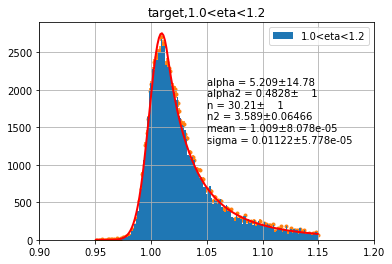

88.36932070970536


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.052141237608714926)


FCN = 260.729702524 
 TOTAL NCALL = 502 
 NCALLS = 502 
 
 
 EDM = 3.66534005611e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.37269,0.0635248,,,,,No
1,alpha2,0.671606,0.0125208,,,,,No
2,n,1.91854,0.29304,,,,,No
3,n2,3.09109,0.0803974,,,,,No
4,mean,1.00009,9.43294e-05,,,,,No
5,sigma,0.00846972,7.42269e-05,,,,,No


FCN = 260.729702524 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 2.30817136516e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.37269,0.0248332,,,,,No
1,alpha2,0.671606,1,,,,,Yes
2,n,1.91854,1,,,,,Yes
3,n2,3.09109,0.0411856,,,,,No
4,mean,1.00009,5.98357e-05,,,,,No
5,sigma,0.00846972,5.0593e-05,,,,,No


0.8<eta<1.0


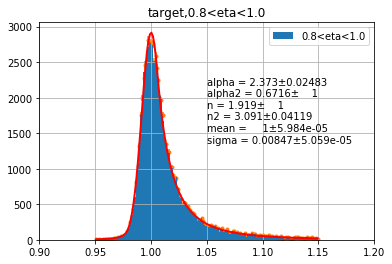

71.5359319627285


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.035154676130584504)


FCN = 222.204080885 
 TOTAL NCALL = 436 
 NCALLS = 436 
 
 
 EDM = 4.07706950264e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.15236,0.0701783,,,,,No
1,alpha2,0.698918,0.0150033,,,,,No
2,n,2.31548,0.357533,,,,,No
3,n2,3.07825,0.0850613,,,,,No
4,mean,0.997561,0.000102099,,,,,No
5,sigma,0.00810518,9.02716e-05,,,,,No


FCN = 222.204080885 
 TOTAL NCALL = 62 
 NCALLS = 62 
 
 
 EDM = 1.73398605361e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.15236,0.0252935,,,,,No
1,alpha2,0.698918,1,,,,,Yes
2,n,2.31548,1,,,,,Yes
3,n2,3.07825,0.0443564,,,,,No
4,mean,0.997561,6.22453e-05,,,,,No
5,sigma,0.00810518,5.62261e-05,,,,,No


0.6<eta<0.8


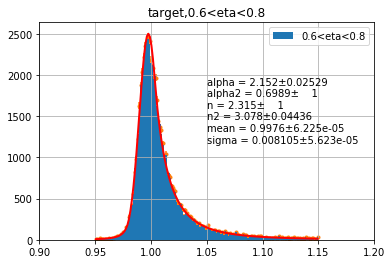

65.36002017577499


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.03427754269424216)


FCN = 254.032311977 
 TOTAL NCALL = 463 
 NCALLS = 463 
 
 
 EDM = 6.47862551933e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.61266,0.0811547,,,,,No
1,alpha2,0.775076,0.0155477,,,,,No
2,n,1.01555,0.233891,,,,,No
3,n2,2.72454,0.071214,,,,,No
4,mean,0.997575,9.58178e-05,,,,,No
5,sigma,0.00822165,7.59386e-05,,,,,No


FCN = 254.032311502 
 TOTAL NCALL = 67 
 NCALLS = 67 
 
 
 EDM = 8.11522283059e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.61266,0.0267806,,,,,No
1,alpha2,0.775076,1,,,,,Yes
2,n,1.01555,1,,,,,Yes
3,n2,2.72454,0.0360895,,,,,No
4,mean,0.997575,6.35579e-05,,,,,No
5,sigma,0.00822169,5.3418e-05,,,,,No


0.4<eta<0.6


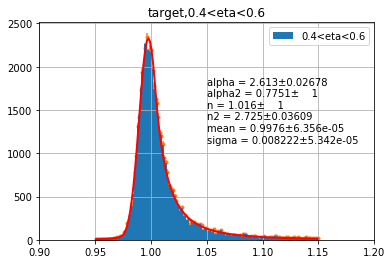

61.20284684101749


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.029291521166349484)


FCN = 182.276358388 
 TOTAL NCALL = 423 
 NCALLS = 423 
 
 
 EDM = 9.64717522509e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.11169,0.0714842,,,,,No
1,alpha2,0.706386,0.0158451,,,,,No
2,n,2.97499,0.473409,,,,,No
3,n2,3.93032,0.128298,,,,,No
4,mean,0.996338,0.000101,,,,,No
5,sigma,0.00765466,8.93386e-05,,,,,No


FCN = 182.276358388 
 TOTAL NCALL = 62 
 NCALLS = 62 
 
 
 EDM = 3.82104416765e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.11169,0.0284453,,,,,No
1,alpha2,0.706386,1,,,,,Yes
2,n,2.97499,1,,,,,Yes
3,n2,3.93032,0.070693,,,,,No
4,mean,0.996338,6.03495e-05,,,,,No
5,sigma,0.00765466,5.40835e-05,,,,,No


0.2<eta<0.4


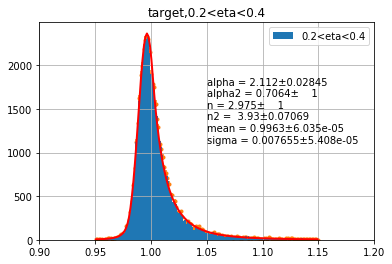

54.27011498451234


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.16206307058502342)


FCN = 174.571956921 
 TOTAL NCALL = 547 
 NCALLS = 547 
 
 
 EDM = 6.54878922765e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.30512,0.0924034,,,,,No
1,alpha2,0.730548,0.0157543,,,,,No
2,n,2.0643,0.434278,,,,,No
3,n2,3.52986,0.111826,,,,,No
4,mean,0.996738,0.000100822,,,,,No
5,sigma,0.00803,8.8248e-05,,,,,No


FCN = 174.571937606 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 3.32351153757e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.3051,0.03145,,,,,No
1,alpha2,0.730548,1,,,,,Yes
2,n,2.0643,1,,,,,Yes
3,n2,3.52978,0.0626705,,,,,No
4,mean,0.996738,6.67151e-05,,,,,No
5,sigma,0.00803022,5.9126e-05,,,,,No


-2.22044604925e-16<eta<0.2


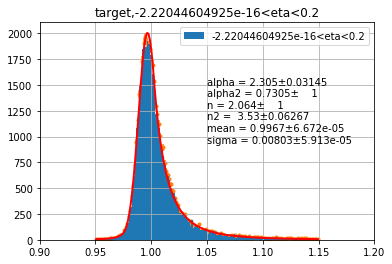

53.12570696274441


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.15998766637208178)


FCN = 171.335187082 
 TOTAL NCALL = 521 
 NCALLS = 521 
 
 
 EDM = 3.145281556e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.29289,0.0894764,,,,,No
1,alpha2,0.775108,0.017291,,,,,No
2,n,2.59572,0.554937,,,,,No
3,n2,3.20598,0.101604,,,,,No
4,mean,0.997025,0.000103901,,,,,No
5,sigma,0.00828534,8.8656e-05,,,,,No


FCN = 171.335169188 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = 2.72932967167e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.29287,0.0350576,,,,,No
1,alpha2,0.775108,1,,,,,Yes
2,n,2.59572,1,,,,,Yes
3,n2,3.20598,0.0537378,,,,,No
4,mean,0.997025,6.85911e-05,,,,,No
5,sigma,0.00828556,6.07885e-05,,,,,No


-0.2<eta<-1.66533453694e-16


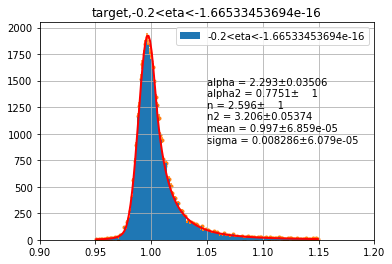

60.274009603262044


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.02975821930766665)


FCN = 173.761799891 
 TOTAL NCALL = 414 
 NCALLS = 414 
 
 
 EDM = 8.63173100355e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.2331,0.0691772,,,,,No
1,alpha2,0.705221,0.0154148,,,,,No
2,n,2.5301,0.401556,,,,,No
3,n2,3.89167,0.127291,,,,,No
4,mean,0.996356,9.95102e-05,,,,,No
5,sigma,0.00764934,8.26022e-05,,,,,No


FCN = 173.761799891 
 TOTAL NCALL = 62 
 NCALLS = 62 
 
 
 EDM = 4.15079371296e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.2331,0.0290991,,,,,No
1,alpha2,0.705221,1,,,,,Yes
2,n,2.5301,1,,,,,Yes
3,n2,3.89167,0.0692482,,,,,No
4,mean,0.996356,6.08711e-05,,,,,No
5,sigma,0.00764934,5.27383e-05,,,,,No


-0.4<eta<-0.2


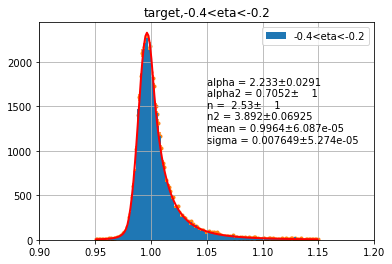

65.36656342506413


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.03600970740921578)


FCN = 224.671772296 
 TOTAL NCALL = 452 
 NCALLS = 452 
 
 
 EDM = 3.82162484854e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.21033,0.0901331,,,,,No
1,alpha2,0.681671,0.0152077,,,,,No
2,n,3.15452,0.636115,,,,,No
3,n2,3.01326,0.0838337,,,,,No
4,mean,0.997297,0.000107667,,,,,No
5,sigma,0.00795498,9.35004e-05,,,,,No


FCN = 224.671772291 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 6.61285782258e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.21033,0.0336295,,,,,No
1,alpha2,0.681671,1,,,,,Yes
2,n,3.15452,1,,,,,Yes
3,n2,3.01326,0.0448705,,,,,No
4,mean,0.997297,6.55198e-05,,,,,No
5,sigma,0.00795499,5.87256e-05,,,,,No


-0.6<eta<-0.4


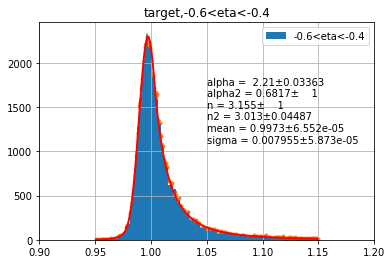

71.14621956825258


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.03549381291707985)


FCN = 210.90609695 
 TOTAL NCALL = 433 
 NCALLS = 433 
 
 
 EDM = 1.06528995304e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.1941,0.0602257,,,,,No
1,alpha2,0.684456,0.0143844,,,,,No
2,n,2.07406,0.288382,,,,,No
3,n2,3.09866,0.0852774,,,,,No
4,mean,0.997284,0.000100988,,,,,No
5,sigma,0.00798534,8.37643e-05,,,,,No


FCN = 210.906096238 
 TOTAL NCALL = 67 
 NCALLS = 67 
 
 
 EDM = 3.3397576364e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.1941,0.0242005,,,,,No
1,alpha2,0.684456,1,,,,,Yes
2,n,2.07406,1,,,,,Yes
3,n2,3.09866,0.0451397,,,,,No
4,mean,0.997284,6.25944e-05,,,,,No
5,sigma,0.00798538,5.55885e-05,,,,,No


-0.8<eta<-0.6


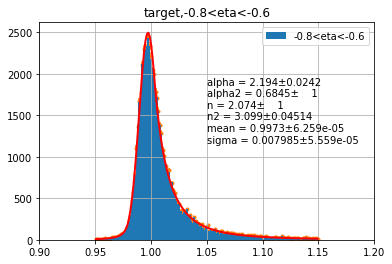

87.26966494242333


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.05270696571254931)


FCN = 265.07518247 
 TOTAL NCALL = 503 
 NCALLS = 503 
 
 
 EDM = 6.05519602161e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.39578,0.0742887,,,,,No
1,alpha2,0.630293,0.0122452,,,,,No
2,n,1.61629,0.272518,,,,,No
3,n2,3.29584,0.0897432,,,,,No
4,mean,0.999898,0.000100437,,,,,No
5,sigma,0.00842193,8.27955e-05,,,,,No


FCN = 265.07518247 
 TOTAL NCALL = 62 
 NCALLS = 62 
 
 
 EDM = 5.76593311323e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.39578,0.0248232,,,,,No
1,alpha2,0.630293,1,,,,,Yes
2,n,1.61629,1,,,,,Yes
3,n2,3.29584,0.047459,,,,,No
4,mean,0.999898,6.1555e-05,,,,,No
5,sigma,0.00842193,5.2636e-05,,,,,No


-1.0<eta<-0.8


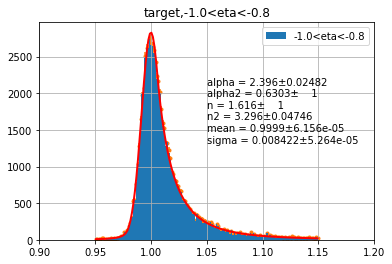

126.11714725494399


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.15041107143098098)


FCN = 445.988029882 
 TOTAL NCALL = 825 
 NCALLS = 825 
 
 
 EDM = 2.34785631408e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.74872,0.127903,,,,,No
1,alpha2,0.411589,0.0088357,,,,,No
2,n,1.69501,0.543306,,,,,No
3,n2,4.34309,0.184212,,,,,No
4,mean,1.00757,0.000150915,,,,,No
5,sigma,0.0100502,0.000104451,,,,,No


FCN = 445.988029864 
 TOTAL NCALL = 68 
 NCALLS = 68 
 
 
 EDM = 6.58284460208e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.74872,0.0360277,,,,,No
1,alpha2,0.411589,1,,,,,Yes
2,n,1.69501,1,,,,,Yes
3,n2,4.34309,0.0966002,,,,,No
4,mean,1.00757,8.01339e-05,,,,,No
5,sigma,0.0100502,6.09402e-05,,,,,No


-1.2<eta<-1.0


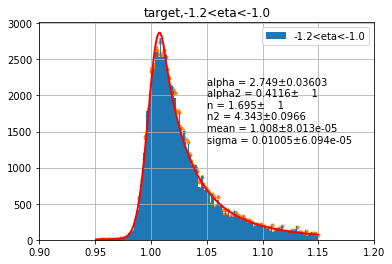

169.99202415148423


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.2264048268880344)


FCN = 581.809202078 
 TOTAL NCALL = 635 
 NCALLS = 624 
 
 
 EDM = 0.241508373569 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.06315,5.74105,,,,,No
1,alpha2,0.401245,5.74105,,,,,No
2,n,19.7935,0.707107,,,,,No
3,n2,5.36725,5.74084,,,,,No
4,mean,1.01466,5.74105,,,,,No
5,sigma,0.0107246,5.74105,,,,,No


FCN = 581.419574484 
 TOTAL NCALL = 77 
 NCALLS = 77 
 
 
 EDM = 4.73851482509e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.08553,0.029499,,,,,No
1,alpha2,0.401245,1,,,,,Yes
2,n,19.7935,1,,,,,Yes
3,n2,5.37002,0.138289,,,,,No
4,mean,1.01465,7.34893e-05,,,,,No
5,sigma,0.0107206,5.76899e-05,,,,,No


-1.4<eta<-1.2


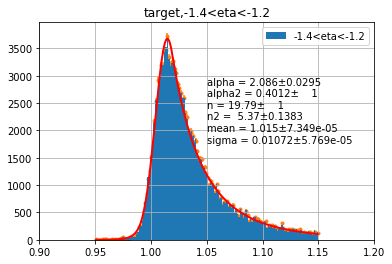

55.603132327397745


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 1.0, -0.1646966634832843)


FCN = 378.51016164 
 TOTAL NCALL = 1003 
 NCALLS = 992 
 
 
 EDM = 2.40050889206e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,3.38637,0.0984354,,,,,No
1,alpha2,0.282037,0.0121821,,,,,No
2,n,1.00297,0.000489806,,,,,No
3,n2,5.74584,1.19669,,,,,No
4,mean,1.02095,0.000251673,,,,,No
5,sigma,0.0111235,0.000156491,,,,,No


FCN = 378.30101536 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = 1.09758983892e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,3.44448,0.10519,,,,,No
1,alpha2,0.282037,1,,,,,Yes
2,n,1.00297,1,,,,,Yes
3,n2,5.76011,0.406556,,,,,No
4,mean,1.02092,0.000165357,,,,,No
5,sigma,0.0111166,0.000112757,,,,,No


-1.6<eta<-1.4


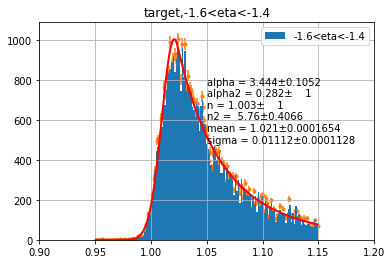

[1.01710329 1.01560494 1.00947204 1.00008541 0.99756085 0.99757549
 0.99633794 0.99673761 0.99702469 0.99635555 0.99729747 0.99728385
 0.99989791 1.0075688  1.01465314 1.02091515]
[0.00984474 0.01138167 0.01121673 0.00846972 0.00810518 0.00822169
 0.00765466 0.00803022 0.00828556 0.00764934 0.00795499 0.00798538
 0.00842193 0.01005022 0.01072064 0.01111657]


In [31]:
n=16
eta=np.zeros((n))
mean=np.zeros((n))
err_mean=np.zeros((n))
sigma=np.zeros((n))
err_sigma=np.zeros((n))
print(mean)
feat=[]
for i in range (n):
    a=1.4-0.2*i
    b=a+0.2
    eta[i]= (a+b)/2
    feat.append(str(a)+'<eta<'+str(b))
i=0
for para in feat:
    plt.figure()
    df=DF.query(para).astype('double')
    df=df.query('eta<1.4442')
    data=np.array(df.query('0.95<target<1.15')['target']).astype('double')
    nbins = 150
    out=plt.hist(data,bins=nbins,label=para,density=0)
    #plt.ylim([0,500])
    
    surface_hist=sum(out[0][:]*np.diff(out[1][:]))
    print(surface_hist)
    plt.title('target,'+para)
    plt.xlim([0.9,1.2])
    
    plt.legend()
    
    rmin = 0.95
    rmax = 1.15
    df=DF.query(para).astype('double')
    
    bound_DCB=[rmin, rmax]
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(2):
        #first step
        
        
        if j==0 and (i==8 or i==7): 
            pars_dcb = dict(mean  = 0.97, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 6,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        elif j==0 and (i!=8 and i!=7):
            pars_dcb = dict(mean  = 1, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 6,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        #optimize parameter withoptimized start parameter
        elif j==1 and i==0:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  =False
                        )
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
        minuit.migrad() #optimized parameter
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.5,0.75))
    
    print(para)
    mean[i]=minuit.values['mean']
    sigma[i]=minuit.values['sigma']
    err_mean[i]=minuit.errors['mean']
    err_sigma[i]=minuit.errors['sigma']
    i+=1
    plt.savefig('target_'+para+'_fit'+'.png')
    plt.show()
print(mean)
print(sigma)
Sigma=sigma

[0.00984474 0.01138167 0.01121673 0.00846972 0.00810518 0.00822169
 0.00765466 0.00803022 0.00828556 0.00764934 0.00795499 0.00798538
 0.00842193 0.01005022 0.01072064 0.01111657]


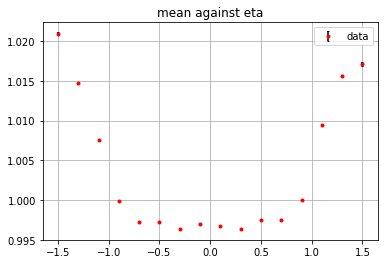

(array([0.00984474, 0.01138167, 0.01121673, 0.00846972, 0.00810518,
       0.00822169, 0.00765466, 0.00803022, 0.00828556, 0.00764934,
       0.00795499, 0.00798538, 0.00842193, 0.01005022, 0.01072064,
       0.01111657]), array([ 1.5,  1.3,  1.1,  0.9,  0.7,  0.5,  0.3,  0.1, -0.1, -0.3, -0.5,
       -0.7, -0.9, -1.1, -1.3, -1.5]))


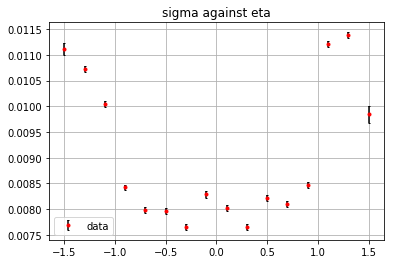

In [32]:
Sigma=sigma
print(Sigma)
X=np.atleast_2d(eta).T
y=mean
x = np.atleast_2d(np.linspace(-1.5, 1.5, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sig = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()

plt.errorbar(eta,mean, yerr=err_mean, fmt='r.',label='data',ecolor='black',capsize=1)
#plt.plot(x, y_pred, 'b-', label=u'Prediction')
#plt.fill(np.concatenate([x, x[::-1]]),
#         np.concatenate([y_pred - 1.9600 * sig,
#                        (y_pred + 1.9600 * sig)[::-1]]),
 #        alpha=.5, fc='b', ec='None', label='95% confidence interval')



plt.title('mean against eta')
#plt.xlabel('$\eta$')
plt.legend()
plt.savefig('mean_against_eta'+'.png')
plt.grid()
plt.show()

Xs=np.atleast_2d(eta).T
ys=Sigma
x = np.atleast_2d(np.linspace(-1.5, 1.5, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
print(Sigma,eta)
gp.fit(Xs, ys)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sig= gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()

plt.errorbar(eta,sigma,yerr=err_sigma,fmt='r.',label='data',ecolor='black',capsize=1)
#plt.plot(x, y_pred, 'b-', label=u'Prediction')
#plt.fill(np.concatenate([x, x[::-1]]),
 #        np.concatenate([y_pred - 1.9600 * sig,
  #                      (y_pred + 1.9600 * sig)[::-1]]),
   #      alpha=.5, fc='b', ec='None', label='95% confidence interval')


plt.xlabel=('$\eta$')
plt.ylabel=('standart deviation of the energy')
plt.title('sigma against eta')
plt.savefig('sigma_against_eta'+'.png')
plt.grid()
plt.legend()
plt.show()

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.008615997278561391)


FCN = 255.424996009 
 TOTAL NCALL = 407 
 NCALLS = 407 
 
 
 EDM = 7.54426445587e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,4.7989,15.3443,,,,,No
1,alpha2,1.19619,0.110993,,,,,No
2,n,14.5742,1124.78,,,,,No
3,n2,2.11119,0.324176,,,,,No
4,mean,0.995862,0.000344403,,,,,No
5,sigma,0.00850838,0.000266489,,,,,No


FCN = 255.424922145 
 TOTAL NCALL = 94 
 NCALLS = 94 
 
 
 EDM = 3.09384026864e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,4.93743,22.9814,,,,,No
1,alpha2,1.19629,0.111144,,,,,No
2,n,20.4781,3736.24,,,,,No
3,n2,2.11147,0.324695,,,,,No
4,mean,0.995861,0.00034458,,,,,No
5,sigma,0.00850934,0.000266672,,,,,No


FCN = 255.424903224 
 TOTAL NCALL = 93 
 NCALLS = 93 
 
 
 EDM = 2.18684695978e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,5.09146,33.7281,,,,,No
1,alpha2,1.19628,0.111074,,,,,No
2,n,30.907,14124.3,,,,,No
3,n2,2.11137,0.324466,,,,,No
4,mean,0.995861,0.000344496,,,,,No
5,sigma,0.00850967,0.000266621,,,,,No


FCN = 255.424899111 
 TOTAL NCALL = 111 
 NCALLS = 111 
 
 
 EDM = 1.97108818368e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,5.18895,43.129,,,,,No
1,alpha2,1.19635,0.111158,,,,,No
2,n,30.907,25487.3,,,,,No
3,n2,2.11147,0.324746,,,,,No
4,mean,0.995861,0.000344594,,,,,No
5,sigma,0.00850976,0.000266687,,,,,No


300<pt<310
0


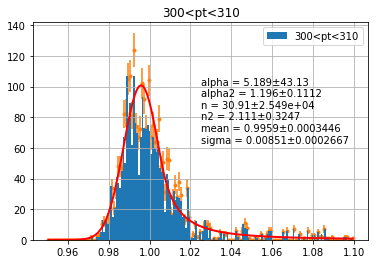

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.03327019331877261)


FCN = 678.140270975 
 TOTAL NCALL = 378 
 NCALLS = 367 
 
 
 EDM = 69061.4239442 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.07352,0,,,,,No
1,alpha2,0.525757,0,,,,,No
2,n,21.8969,0,,,,,No
3,n2,48.7031,0,,,,,No
4,mean,0.998259,0,,,,,No
5,sigma,0.00782086,0,,,,,No


FCN = 674.018067414 
 TOTAL NCALL = 216 
 NCALLS = 205 
 
 
 EDM = 4469.57666385 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.18168,0.120362,,,,,No
1,alpha2,0.522714,0.0105913,,,,,No
2,n,21.8974,0.283853,,,,,No
3,n2,122.886,60.4669,,,,,No
4,mean,0.998308,0.000143022,,,,,No
5,sigma,0.00785728,9.67739e-05,,,,,No


FCN = 674.018067414 
 TOTAL NCALL = 70 
 NCALLS = 59 
 
 
 EDM = 0.225315179723 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.18168,0,,,,,No
1,alpha2,0.522714,0,,,,,No
2,n,21.8974,0,,,,,No
3,n2,122.886,0,,,,,No
4,mean,0.998308,0,,,,,No
5,sigma,0.00785728,0,,,,,No


FCN = 674.018067414 
 TOTAL NCALL = 70 
 NCALLS = 59 
 
 
 EDM = 0.225315179723 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.18168,0,,,,,No
1,alpha2,0.522714,0,,,,,No
2,n,21.8974,0,,,,,No
3,n2,122.886,0,,,,,No
4,mean,0.998308,0,,,,,No
5,sigma,0.00785728,0,,,,,No


290<pt<300
1


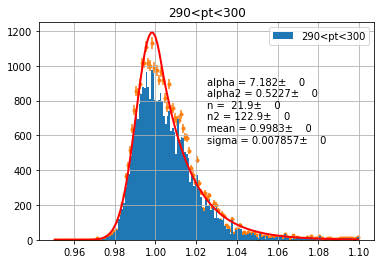

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.042045995011135054)


FCN = 506.400259949 
 TOTAL NCALL = 430 
 NCALLS = 430 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,30.496,nan,,,,,No
1,alpha2,0.435084,nan,,,,,No
2,n,232.235,nan,,,,,No
3,n2,106.931,nan,,,,,No
4,mean,0.998529,nan,,,,,No
5,sigma,0.00771051,nan,,,,,No


FCN = 506.400259949 
 TOTAL NCALL = 72 
 NCALLS = 61 
 
 
 EDM = 0.989886308495 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,30.496,0,,,,,No
1,alpha2,0.435084,0,,,,,No
2,n,232.235,0,,,,,No
3,n2,106.931,0,,,,,No
4,mean,0.998529,0,,,,,No
5,sigma,0.00771051,0,,,,,No


FCN = 506.400259949 
 TOTAL NCALL = 72 
 NCALLS = 61 
 
 
 EDM = 0.989886308495 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,30.496,0,,,,,No
1,alpha2,0.435084,0,,,,,No
2,n,232.235,0,,,,,No
3,n2,106.931,0,,,,,No
4,mean,0.998529,0,,,,,No
5,sigma,0.00771051,0,,,,,No


FCN = 506.400259949 
 TOTAL NCALL = 72 
 NCALLS = 61 
 
 
 EDM = 0.989886308495 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,30.496,0,,,,,No
1,alpha2,0.435084,0,,,,,No
2,n,232.235,0,,,,,No
3,n2,106.931,0,,,,,No
4,mean,0.998529,0,,,,,No
5,sigma,0.00771051,0,,,,,No


280<pt<290
2


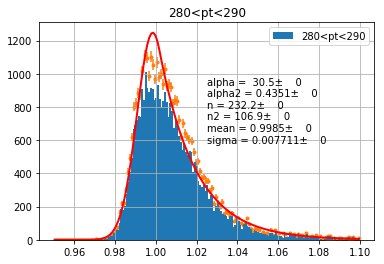

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.04717694987064462)


FCN = 576.451315842 
 TOTAL NCALL = 486 
 NCALLS = 486 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,19.5429,nan,,,,,No
1,alpha2,0.394388,nan,,,,,No
2,n,96.4956,nan,,,,,No
3,n2,29.5327,nan,,,,,No
4,mean,0.997836,nan,,,,,No
5,sigma,0.00746382,nan,,,,,No


FCN = 569.909201477 
 TOTAL NCALL = 227 
 NCALLS = 216 
 
 
 EDM = 4252.54753632 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,21.391,0.343277,,,,,No
1,alpha2,0.377755,0.00811207,,,,,No
2,n,96.4956,3.91232,,,,,No
3,n2,113.761,73.0934,,,,,No
4,mean,0.997682,0.000156147,,,,,No
5,sigma,0.00740317,9.94239e-05,,,,,No


FCN = 569.909201477 
 TOTAL NCALL = 72 
 NCALLS = 61 
 
 
 EDM = 0.0793516604586 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,21.391,0,,,,,No
1,alpha2,0.377755,0,,,,,No
2,n,96.4956,0,,,,,No
3,n2,113.761,0,,,,,No
4,mean,0.997682,0,,,,,No
5,sigma,0.00740317,0,,,,,No


FCN = 569.909201477 
 TOTAL NCALL = 72 
 NCALLS = 61 
 
 
 EDM = 0.0793516604586 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,21.391,0,,,,,No
1,alpha2,0.377755,0,,,,,No
2,n,96.4956,0,,,,,No
3,n2,113.761,0,,,,,No
4,mean,0.997682,0,,,,,No
5,sigma,0.00740317,0,,,,,No


270<pt<280
3


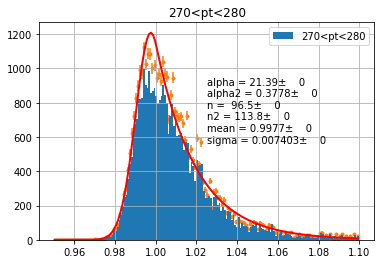

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.0466670813520092)


FCN = 574.916851875 
 TOTAL NCALL = 476 
 NCALLS = 465 
 
 
 EDM = 1808182588.22 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,8.04093,2.81642,,,,,No
1,alpha2,0.41641,2.81643,,,,,No
2,n,44.6891,2.83279,,,,,No
3,n2,40.5662,0.707107,,,,,No
4,mean,0.998552,2.81641,,,,,No
5,sigma,0.00780616,2.81641,,,,,No


FCN = 572.036033159 
 TOTAL NCALL = 73 
 NCALLS = 73 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,8.04093,nan,,,,,No
1,alpha2,0.409833,nan,,,,,No
2,n,44.6891,nan,,,,,No
3,n2,61.7162,nan,,,,,No
4,mean,0.998489,nan,,,,,No
5,sigma,0.00778943,nan,,,,,No


FCN = 569.870807554 
 TOTAL NCALL = 73 
 NCALLS = 73 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,8.04093,nan,,,,,No
1,alpha2,0.402891,nan,,,,,No
2,n,44.6891,nan,,,,,No
3,n2,98.3347,nan,,,,,No
4,mean,0.998438,nan,,,,,No
5,sigma,0.00772794,nan,,,,,No


FCN = 568.969457639 
 TOTAL NCALL = 78 
 NCALLS = 78 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,8.04093,nan,,,,,No
1,alpha2,0.403052,nan,,,,,No
2,n,44.6891,nan,,,,,No
3,n2,120.602,nan,,,,,No
4,mean,0.998386,nan,,,,,No
5,sigma,0.00771914,nan,,,,,No


260<pt<270
4


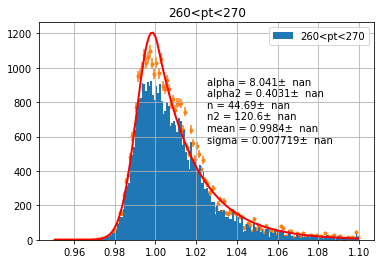

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.049367221503540865)


FCN = 375.841292784 
 TOTAL NCALL = 486 
 NCALLS = 486 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,17.5738,nan,,,,,No
1,alpha2,0.382901,nan,,,,,No
2,n,70.3398,nan,,,,,No
3,n2,53.5039,nan,,,,,No
4,mean,0.998358,nan,,,,,No
5,sigma,0.00760041,nan,,,,,No


FCN = 373.389823932 
 TOTAL NCALL = 99 
 NCALLS = 88 
 
 
 EDM = 1.06122459244 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,17.5738,0,,,,,No
1,alpha2,0.381628,0,,,,,No
2,n,70.3398,0,,,,,No
3,n2,98.2646,0,,,,,No
4,mean,0.998372,0,,,,,No
5,sigma,0.00761013,0,,,,,No


FCN = 372.571823124 
 TOTAL NCALL = 88 
 NCALLS = 77 
 
 
 EDM = 0.602655482261 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,17.5738,0,,,,,No
1,alpha2,0.379454,0,,,,,No
2,n,70.3398,0,,,,,No
3,n2,104.208,0,,,,,No
4,mean,0.998382,0,,,,,No
5,sigma,0.00763169,0,,,,,No


FCN = 372.571823124 
 TOTAL NCALL = 72 
 NCALLS = 61 
 
 
 EDM = 0.437265406929 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,17.5738,0,,,,,No
1,alpha2,0.379454,0,,,,,No
2,n,70.3398,0,,,,,No
3,n2,104.208,0,,,,,No
4,mean,0.998382,0,,,,,No
5,sigma,0.00763169,0,,,,,No


250<pt<260
5


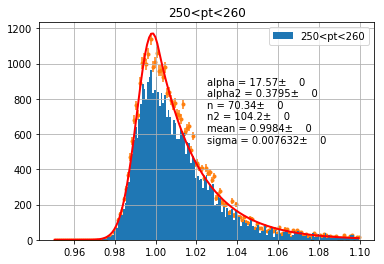

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.0498642394958018)


FCN = 479.358183294 
 TOTAL NCALL = 428 
 NCALLS = 428 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,10.9417,nan,,,,,No
1,alpha2,0.412124,nan,,,,,No
2,n,58.7676,nan,,,,,No
3,n2,35.4979,nan,,,,,No
4,mean,0.998905,nan,,,,,No
5,sigma,0.00786444,nan,,,,,No


FCN = 464.519206637 
 TOTAL NCALL = 147 
 NCALLS = 136 
 
 
 EDM = 30119.526643 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,10.9418,0,,,,,No
1,alpha2,0.407657,0,,,,,No
2,n,58.7676,0,,,,,No
3,n2,121.961,0,,,,,No
4,mean,0.999052,0,,,,,No
5,sigma,0.00797304,0,,,,,No


FCN = 464.519206637 
 TOTAL NCALL = 111 
 NCALLS = 100 
 
 
 EDM = 95643.1765086 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,10.9418,0.017367,,,,,No
1,alpha2,0.407657,0.00681772,,,,,No
2,n,58.7676,0.860598,,,,,No
3,n2,121.961,52.9143,,,,,No
4,mean,0.999052,0.00013648,,,,,No
5,sigma,0.00797304,8.80903e-05,,,,,No


FCN = 464.519206637 
 TOTAL NCALL = 111 
 NCALLS = 100 
 
 
 EDM = 95643.1765086 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,10.9418,0.017367,,,,,No
1,alpha2,0.407657,0.00681772,,,,,No
2,n,58.7676,0.860598,,,,,No
3,n2,121.961,52.9143,,,,,No
4,mean,0.999052,0.00013648,,,,,No
5,sigma,0.00797304,8.80903e-05,,,,,No


240<pt<250
6


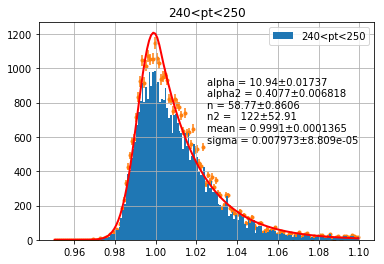

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.05080652468416463)


FCN = 4151.25068398 
 TOTAL NCALL = 170 
 NCALLS = 159 
 
 
 EDM = 1533.15459516 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.0100348,,,,,No
1,alpha2,1,0.0803062,,,,,No
2,n,4,0.0747053,,,,,No
3,n2,2.63227,0.962943,,,,,No
4,mean,1.002,8.3673e-05,,,,,No
5,sigma,0.01,0.000315887,,,,,No


FCN = 2582.09304361 
 TOTAL NCALL = 118 
 NCALLS = 107 
 
 
 EDM = 23300.8008573 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.15009,0.00828428,,,,,No
1,alpha2,0.585058,0.0172675,,,,,No
2,n,4.47208,0.0709256,,,,,No
3,n2,5.81715,0.216451,,,,,No
4,mean,1.00227,7.15878e-05,,,,,No
5,sigma,0.0101425,8.98437e-05,,,,,No


FCN = 510.408752222 
 TOTAL NCALL = 418 
 NCALLS = 418 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,9.52503,nan,,,,,No
1,alpha2,0.372502,nan,,,,,No
2,n,95.5357,nan,,,,,No
3,n2,105.527,nan,,,,,No
4,mean,0.998567,nan,,,,,No
5,sigma,0.00768047,nan,,,,,No


FCN = 510.408752222 
 TOTAL NCALL = 115 
 NCALLS = 104 
 
 
 EDM = 349432.63181 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,9.52503,0.00938173,,,,,No
1,alpha2,0.372502,0.00632429,,,,,No
2,n,95.5357,0.939944,,,,,No
3,n2,105.527,44.3963,,,,,No
4,mean,0.998567,0.000138117,,,,,No
5,sigma,0.00768047,8.767e-05,,,,,No


230<pt<240
7


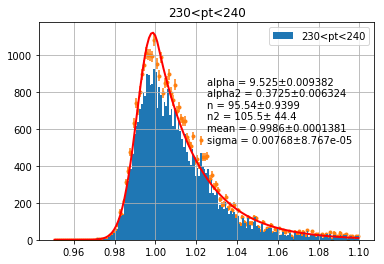

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.05341168019800618)


FCN = 4492.33347824 
 TOTAL NCALL = 170 
 NCALLS = 159 
 
 
 EDM = 112981.437474 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.00708603,,,,,No
1,alpha2,1,0.0551945,,,,,No
2,n,4,0.0429241,,,,,No
3,n2,2.90508,1.63259,,,,,No
4,mean,1.002,0.0001404,,,,,No
5,sigma,0.01,0.000343422,,,,,No


FCN = 4492.33347824 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 110051.443848 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.00685126,,,,,No
1,alpha2,1,0.0579041,,,,,No
2,n,4,0.0433953,,,,,No
3,n2,2.90508,1.64725,,,,,No
4,mean,1.002,0.000140949,,,,,No
5,sigma,0.01,0.000324417,,,,,No


FCN = 4492.33347824 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 110051.443848 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.00685126,,,,,No
1,alpha2,1,0.0579041,,,,,No
2,n,4,0.0433953,,,,,No
3,n2,2.90508,1.64725,,,,,No
4,mean,1.002,0.000140949,,,,,No
5,sigma,0.01,0.000324417,,,,,No


FCN = 4492.33347824 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 110051.443848 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.00685126,,,,,No
1,alpha2,1,0.0579041,,,,,No
2,n,4,0.0433953,,,,,No
3,n2,2.90508,1.64725,,,,,No
4,mean,1.002,0.000140949,,,,,No
5,sigma,0.01,0.000324417,,,,,No


220<pt<230
8


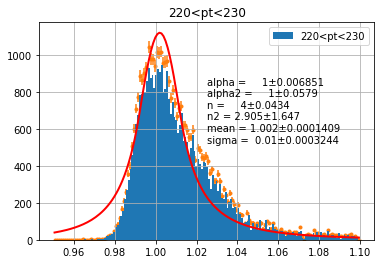

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.05150583229482658)


FCN = 2056.54608765 
 TOTAL NCALL = 207 
 NCALLS = 196 
 
 
 EDM = 10614790324.2 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.28927,0.709927,,,,,No
1,alpha2,0.730429,0.709872,,,,,No
2,n,5.15899,0.712544,,,,,No
3,n2,2.24989,0.707132,,,,,No
4,mean,1.00281,0.10049,,,,,No
5,sigma,0.00893374,0.702821,,,,,No


FCN = 415.42134257 
 TOTAL NCALL = 328 
 NCALLS = 328 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,9.38311,nan,,,,,No
1,alpha2,0.413513,nan,,,,,No
2,n,46.7824,nan,,,,,No
3,n2,19.5979,nan,,,,,No
4,mean,0.999191,nan,,,,,No
5,sigma,0.00807499,nan,,,,,No


FCN = 392.613280528 
 TOTAL NCALL = 199 
 NCALLS = 199 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,22.4402,nan,,,,,No
1,alpha2,0.385297,nan,,,,,No
2,n,177.353,nan,,,,,No
3,n2,91.3869,nan,,,,,No
4,mean,0.998929,nan,,,,,No
5,sigma,0.00793643,nan,,,,,No


FCN = 391.334922398 
 TOTAL NCALL = 99 
 NCALLS = 88 
 
 
 EDM = 0.341591228067 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,22.4402,0,,,,,No
1,alpha2,0.384969,0,,,,,No
2,n,177.353,0,,,,,No
3,n2,118.306,0,,,,,No
4,mean,0.998984,0,,,,,No
5,sigma,0.0079246,0,,,,,No


210<pt<220
9


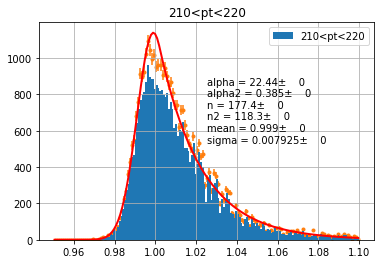

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.05398408831613604)


FCN = 436.358511938 
 TOTAL NCALL = 470 
 NCALLS = 470 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,9.15692,nan,,,,,No
1,alpha2,0.449035,nan,,,,,No
2,n,53.4162,nan,,,,,No
3,n2,20.4162,nan,,,,,No
4,mean,1.00066,nan,,,,,No
5,sigma,0.00880064,nan,,,,,No


FCN = 427.052906007 
 TOTAL NCALL = 72 
 NCALLS = 72 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,9.15692,nan,,,,,No
1,alpha2,0.439481,nan,,,,,No
2,n,53.4162,nan,,,,,No
3,n2,34.9886,nan,,,,,No
4,mean,1.00071,nan,,,,,No
5,sigma,0.00887442,nan,,,,,No


FCN = 417.568292045 
 TOTAL NCALL = 205 
 NCALLS = 194 
 
 
 EDM = 0.158500293727 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,17.7547,0.00663613,,,,,No
1,alpha2,0.416518,0.00705989,,,,,No
2,n,139.394,0.871121,,,,,No
3,n2,110.837,36.0926,,,,,No
4,mean,1.00039,0.000151891,,,,,No
5,sigma,0.00867733,0.000100724,,,,,No


FCN = 417.568292045 
 TOTAL NCALL = 117 
 NCALLS = 106 
 
 
 EDM = 59148.0380048 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,17.7547,0.0322784,,,,,No
1,alpha2,0.416518,0.00666038,,,,,No
2,n,139.394,0.8609,,,,,No
3,n2,110.837,40.5449,,,,,No
4,mean,1.00039,0.000142723,,,,,No
5,sigma,0.00867733,9.30302e-05,,,,,No


200<pt<210
10


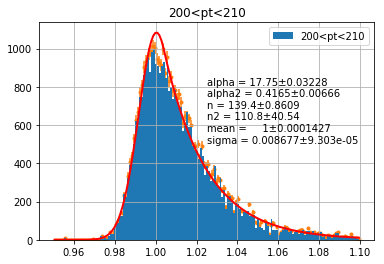

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.058510780234552216)


FCN = 364.389211578 
 TOTAL NCALL = 651 
 NCALLS = 640 
 
 
 EDM = 0.37547131458 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.81482,0.163445,,,,,No
1,alpha2,0.361863,0.00644196,,,,,No
2,n,23.8712,0.174462,,,,,No
3,n2,114.638,23.8969,,,,,No
4,mean,0.999446,0.000154956,,,,,No
5,sigma,0.00812773,0.000104376,,,,,No


FCN = 364.291989221 
 TOTAL NCALL = 118 
 NCALLS = 107 
 
 
 EDM = 1.04126802652 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.81482,0.227789,,,,,No
1,alpha2,0.361863,0.00636911,,,,,No
2,n,14.9334,18.2361,,,,,No
3,n2,114.638,34.3574,,,,,No
4,mean,0.999446,0.000157447,,,,,No
5,sigma,0.00812773,0.000105166,,,,,No


FCN = 364.291989221 
 TOTAL NCALL = 95 
 NCALLS = 84 
 
 
 EDM = 1.03751026318 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.81482,0.227201,,,,,No
1,alpha2,0.361863,0.00578874,,,,,No
2,n,14.9334,18.2999,,,,,No
3,n2,114.638,34.3887,,,,,No
4,mean,0.999446,0.000144171,,,,,No
5,sigma,0.00812773,9.47282e-05,,,,,No


FCN = 364.291989221 
 TOTAL NCALL = 95 
 NCALLS = 84 
 
 
 EDM = 1.03751026318 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.81482,0.227201,,,,,No
1,alpha2,0.361863,0.00578874,,,,,No
2,n,14.9334,18.2999,,,,,No
3,n2,114.638,34.3887,,,,,No
4,mean,0.999446,0.000144171,,,,,No
5,sigma,0.00812773,9.47282e-05,,,,,No


190<pt<200
11


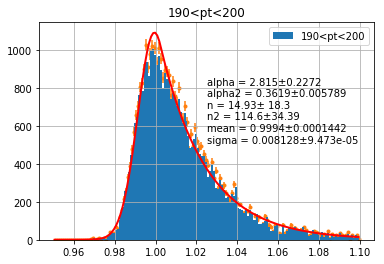

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.062059762850068624)


FCN = 496.892181087 
 TOTAL NCALL = 440 
 NCALLS = 440 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,17.0293,nan,,,,,No
1,alpha2,0.385233,nan,,,,,No
2,n,89.1808,nan,,,,,No
3,n2,23.6726,nan,,,,,No
4,mean,1.0004,nan,,,,,No
5,sigma,0.0085727,nan,,,,,No


FCN = 468.287940165 
 TOTAL NCALL = 253 
 NCALLS = 242 
 
 
 EDM = 195362.780617 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,18.2916,0.0190162,,,,,No
1,alpha2,0.368075,0.00627699,,,,,No
2,n,89.1808,3.87294,,,,,No
3,n2,110.641,28.3319,,,,,No
4,mean,1.00025,0.000161643,,,,,No
5,sigma,0.00851462,0.000104619,,,,,No


FCN = 468.287940165 
 TOTAL NCALL = 74 
 NCALLS = 63 
 
 
 EDM = 1.73244435409 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,18.2916,0,,,,,No
1,alpha2,0.368075,0,,,,,No
2,n,89.1808,0,,,,,No
3,n2,110.641,0,,,,,No
4,mean,1.00025,0,,,,,No
5,sigma,0.00851462,0,,,,,No


FCN = 468.287940165 
 TOTAL NCALL = 74 
 NCALLS = 63 
 
 
 EDM = 1.73244435409 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,18.2916,0,,,,,No
1,alpha2,0.368075,0,,,,,No
2,n,89.1808,0,,,,,No
3,n2,110.641,0,,,,,No
4,mean,1.00025,0,,,,,No
5,sigma,0.00851462,0,,,,,No


180<pt<190
12


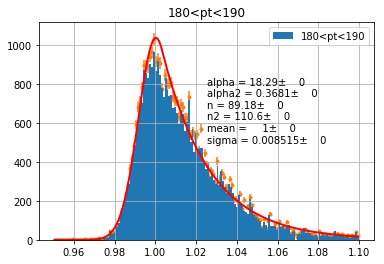

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.06417890905690139)


FCN = 396.391446255 
 TOTAL NCALL = 434 
 NCALLS = 434 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,18.2068,nan,,,,,No
1,alpha2,0.392725,nan,,,,,No
2,n,103.406,nan,,,,,No
3,n2,22.4493,nan,,,,,No
4,mean,1.00073,nan,,,,,No
5,sigma,0.0089095,nan,,,,,No


FCN = 376.321550419 
 TOTAL NCALL = 295 
 NCALLS = 295 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,16.643,nan,,,,,No
1,alpha2,0.369303,nan,,,,,No
2,n,138.958,nan,,,,,No
3,n2,121.875,nan,,,,,No
4,mean,1.00048,nan,,,,,No
5,sigma,0.0088018,nan,,,,,No


FCN = 376.321550419 
 TOTAL NCALL = 120 
 NCALLS = 120 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,16.643,nan,,,,,No
1,alpha2,0.369303,nan,,,,,No
2,n,138.958,nan,,,,,No
3,n2,121.875,nan,,,,,No
4,mean,1.00048,nan,,,,,No
5,sigma,0.0088018,nan,,,,,No


FCN = 376.321550419 
 TOTAL NCALL = 120 
 NCALLS = 120 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,16.643,nan,,,,,No
1,alpha2,0.369303,nan,,,,,No
2,n,138.958,nan,,,,,No
3,n2,121.875,nan,,,,,No
4,mean,1.00048,nan,,,,,No
5,sigma,0.0088018,nan,,,,,No


170<pt<180
13


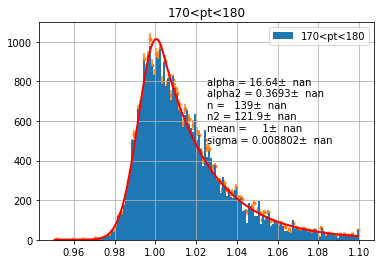

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.002, -0.06825836238851819)


FCN = 388.586213846 
 TOTAL NCALL = 601 
 NCALLS = 590 
 
 
 EDM = 0.137263115248 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,10.126,0.549617,,,,,No
1,alpha2,0.377351,0.00629017,,,,,No
2,n,66.5052,1.55778,,,,,No
3,n2,114.355,27.0177,,,,,No
4,mean,1.00149,0.000142202,,,,,No
5,sigma,0.00930785,0.000101205,,,,,No


FCN = 388.586213846 
 TOTAL NCALL = 113 
 NCALLS = 102 
 
 
 EDM = 58579.5009066 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,10.126,0.0204062,,,,,No
1,alpha2,0.377351,0.00600159,,,,,No
2,n,66.5052,0.896526,,,,,No
3,n2,114.355,35.5931,,,,,No
4,mean,1.00149,0.00016012,,,,,No
5,sigma,0.00930785,0.000103162,,,,,No


FCN = 388.586213846 
 TOTAL NCALL = 113 
 NCALLS = 102 
 
 
 EDM = 58579.5009066 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,10.126,0.0204062,,,,,No
1,alpha2,0.377351,0.00600159,,,,,No
2,n,66.5052,0.896526,,,,,No
3,n2,114.355,35.5931,,,,,No
4,mean,1.00149,0.00016012,,,,,No
5,sigma,0.00930785,0.000103162,,,,,No


FCN = 388.586213846 
 TOTAL NCALL = 113 
 NCALLS = 102 
 
 
 EDM = 58579.5009066 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,10.126,0.0204062,,,,,No
1,alpha2,0.377351,0.00600159,,,,,No
2,n,66.5052,0.896526,,,,,No
3,n2,114.355,35.5931,,,,,No
4,mean,1.00149,0.00016012,,,,,No
5,sigma,0.00930785,0.000103162,,,,,No


160<pt<170
14


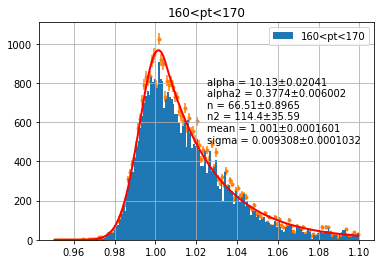

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.07950491911757651)


FCN = 428.211732315 
 TOTAL NCALL = 588 
 NCALLS = 577 
 
 
 EDM = 0.464715913962 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,9.74541,0.283506,,,,,No
1,alpha2,0.36136,0.00593773,,,,,No
2,n,68.2531,0.729939,,,,,No
3,n2,119.675,26.688,,,,,No
4,mean,1.00126,0.000164672,,,,,No
5,sigma,0.00927216,0.00010708,,,,,No


FCN = 428.211732315 
 TOTAL NCALL = 113 
 NCALLS = 102 
 
 
 EDM = 141194.08469 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,9.74541,0.0135876,,,,,No
1,alpha2,0.36136,0.00576521,,,,,No
2,n,68.2531,0.957755,,,,,No
3,n2,119.675,43.1502,,,,,No
4,mean,1.00126,0.000160212,,,,,No
5,sigma,0.00927216,0.000102472,,,,,No


FCN = 428.211732315 
 TOTAL NCALL = 113 
 NCALLS = 102 
 
 
 EDM = 141194.08469 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,9.74541,0.0135876,,,,,No
1,alpha2,0.36136,0.00576521,,,,,No
2,n,68.2531,0.957755,,,,,No
3,n2,119.675,43.1502,,,,,No
4,mean,1.00126,0.000160212,,,,,No
5,sigma,0.00927216,0.000102472,,,,,No


FCN = 428.211732315 
 TOTAL NCALL = 113 
 NCALLS = 102 
 
 
 EDM = 141194.08469 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,9.74541,0.0135876,,,,,No
1,alpha2,0.36136,0.00576521,,,,,No
2,n,68.2531,0.957755,,,,,No
3,n2,119.675,43.1502,,,,,No
4,mean,1.00126,0.000160212,,,,,No
5,sigma,0.00927216,0.000102472,,,,,No


150<pt<160
15


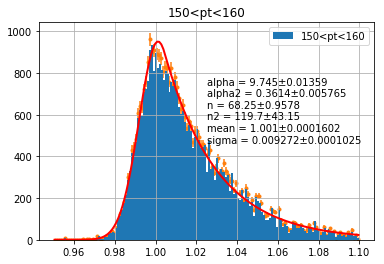

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.08469987082337949)


FCN = 490.042637849 
 TOTAL NCALL = 497 
 NCALLS = 486 
 
 
 EDM = 1860.28212048 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.64989,0.291558,,,,,No
1,alpha2,0.419986,0.00712986,,,,,No
2,n,55.607,0.023668,,,,,No
3,n2,19.8826,1.67273,,,,,No
4,mean,1.00343,0.000168002,,,,,No
5,sigma,0.0107507,0.000114872,,,,,No


FCN = 475.399898874 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.64989,nan,,,,,No
1,alpha2,0.411491,nan,,,,,No
2,n,55.607,nan,,,,,No
3,n2,33.9934,nan,,,,,No
4,mean,1.00343,nan,,,,,No
5,sigma,0.0107007,nan,,,,,No


FCN = 466.610092833 
 TOTAL NCALL = 72 
 NCALLS = 72 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.64989,nan,,,,,No
1,alpha2,0.404303,nan,,,,,No
2,n,55.607,nan,,,,,No
3,n2,63.1003,nan,,,,,No
4,mean,1.0033,nan,,,,,No
5,sigma,0.0106792,nan,,,,,No


FCN = 462.742803337 
 TOTAL NCALL = 78 
 NCALLS = 78 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.64989,nan,,,,,No
1,alpha2,0.404532,nan,,,,,No
2,n,55.607,nan,,,,,No
3,n2,92.6052,nan,,,,,No
4,mean,1.00327,nan,,,,,No
5,sigma,0.0106158,nan,,,,,No


140<pt<150
16


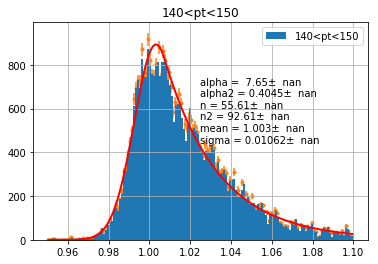

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.08910067217996408)


FCN = 554.736482894 
 TOTAL NCALL = 302 
 NCALLS = 302 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.4516,nan,,,,,No
1,alpha2,0.525955,nan,,,,,No
2,n,28.5875,nan,,,,,No
3,n2,3.21367,nan,,,,,No
4,mean,1.00372,nan,,,,,No
5,sigma,0.0103702,nan,,,,,No


FCN = 451.634681477 
 TOTAL NCALL = 71 
 NCALLS = 71 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.4516,nan,,,,,No
1,alpha2,0.455823,nan,,,,,No
2,n,28.5875,nan,,,,,No
3,n2,5.61417,nan,,,,,No
4,mean,1.00387,nan,,,,,No
5,sigma,0.0110676,nan,,,,,No


FCN = 411.420203503 
 TOTAL NCALL = 67 
 NCALLS = 67 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.4516,nan,,,,,No
1,alpha2,0.427113,nan,,,,,No
2,n,28.5875,nan,,,,,No
3,n2,8.12624,nan,,,,,No
4,mean,1.00383,nan,,,,,No
5,sigma,0.010754,nan,,,,,No


FCN = 389.53168268 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.4516,nan,,,,,No
1,alpha2,0.413242,nan,,,,,No
2,n,28.5875,nan,,,,,No
3,n2,10.9902,nan,,,,,No
4,mean,1.00339,nan,,,,,No
5,sigma,0.0107938,nan,,,,,No


130<pt<140
17


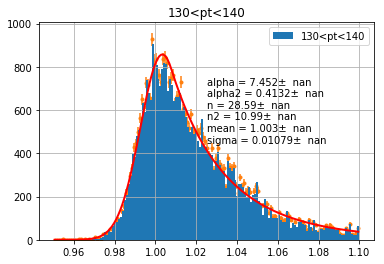

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.09329779054706802)


FCN = 665.965790856 
 TOTAL NCALL = 398 
 NCALLS = 398 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,12.7692,nan,,,,,No
1,alpha2,0.473728,nan,,,,,No
2,n,47.4095,nan,,,,,No
3,n2,4.30722,nan,,,,,No
4,mean,1.00462,nan,,,,,No
5,sigma,0.0111441,nan,,,,,No


FCN = 605.255879186 
 TOTAL NCALL = 72 
 NCALLS = 72 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,12.7692,nan,,,,,No
1,alpha2,0.445983,nan,,,,,No
2,n,47.4095,nan,,,,,No
3,n2,6.83323,nan,,,,,No
4,mean,1.00476,nan,,,,,No
5,sigma,0.0113988,nan,,,,,No


FCN = 548.428215302 
 TOTAL NCALL = 144 
 NCALLS = 144 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,12.7692,nan,,,,,No
1,alpha2,0.394695,nan,,,,,No
2,n,47.4096,nan,,,,,No
3,n2,16.8795,nan,,,,,No
4,mean,1.00409,nan,,,,,No
5,sigma,0.0111552,nan,,,,,No


FCN = 516.910087523 
 TOTAL NCALL = 182 
 NCALLS = 182 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,25.5989,nan,,,,,No
1,alpha2,0.369794,nan,,,,,No
2,n,175.706,nan,,,,,No
3,n2,66.645,nan,,,,,No
4,mean,1.00384,nan,,,,,No
5,sigma,0.010823,nan,,,,,No


120<pt<130
18


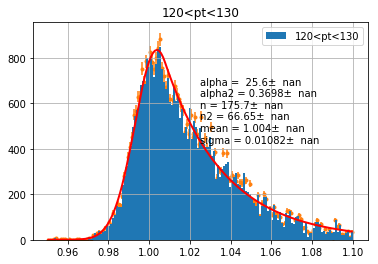

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.10003447507503783)


FCN = 441.581515568 
 TOTAL NCALL = 593 
 NCALLS = 582 
 
 
 EDM = 1512.1064692 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.8734,0,,,,,No
1,alpha2,-0.343317,0,,,,,No
2,n,50.403,0,,,,,No
3,n2,46.3927,0,,,,,No
4,mean,1.00453,0,,,,,No
5,sigma,0.0112227,0,,,,,No


FCN = 428.711450935 
 TOTAL NCALL = 80 
 NCALLS = 80 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.8734,nan,,,,,No
1,alpha2,-0.351162,nan,,,,,No
2,n,50.403,nan,,,,,No
3,n2,76.0982,nan,,,,,No
4,mean,1.00431,nan,,,,,No
5,sigma,0.0113075,nan,,,,,No


FCN = 427.581732764 
 TOTAL NCALL = 90 
 NCALLS = 79 
 
 
 EDM = 0.988229961385 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.8734,0,,,,,No
1,alpha2,-0.350877,0,,,,,No
2,n,50.403,0,,,,,No
3,n2,108.464,0,,,,,No
4,mean,1.00436,0,,,,,No
5,sigma,0.0112759,0,,,,,No


FCN = 427.581732764 
 TOTAL NCALL = 70 
 NCALLS = 59 
 
 
 EDM = 3.93042045478 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,7.8734,0,,,,,No
1,alpha2,-0.350877,0,,,,,No
2,n,50.403,0,,,,,No
3,n2,108.464,0,,,,,No
4,mean,1.00436,0,,,,,No
5,sigma,0.0112759,0,,,,,No


110<pt<120
19


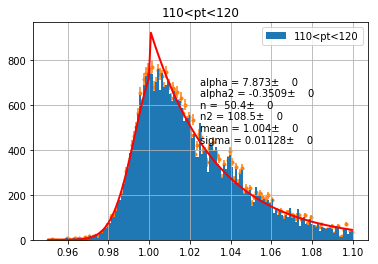

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.10575766114475045)


FCN = 3749.13527594 
 TOTAL NCALL = 199 
 NCALLS = 188 
 
 
 EDM = 16820.2615554 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.00817274,,,,,No
1,alpha2,0.479091,0.037305,,,,,No
2,n,4,0.0606225,,,,,No
3,n2,2.2049,1.07611,,,,,No
4,mean,0.9998,0.000175548,,,,,No
5,sigma,0.01,0.000546714,,,,,No


FCN = 3749.13527594 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 13460.4149133 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.00787565,,,,,No
1,alpha2,0.479091,0.0392402,,,,,No
2,n,4,0.060904,,,,,No
3,n2,2.2049,1.08162,,,,,No
4,mean,0.9998,0.000172815,,,,,No
5,sigma,0.01,0.00050544,,,,,No


FCN = 3749.13527594 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 13460.4149133 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.00787565,,,,,No
1,alpha2,0.479091,0.0392402,,,,,No
2,n,4,0.060904,,,,,No
3,n2,2.2049,1.08162,,,,,No
4,mean,0.9998,0.000172815,,,,,No
5,sigma,0.01,0.00050544,,,,,No


FCN = 3749.13527594 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 13460.4149133 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.00787565,,,,,No
1,alpha2,0.479091,0.0392402,,,,,No
2,n,4,0.060904,,,,,No
3,n2,2.2049,1.08162,,,,,No
4,mean,0.9998,0.000172815,,,,,No
5,sigma,0.01,0.00050544,,,,,No


100<pt<110
20


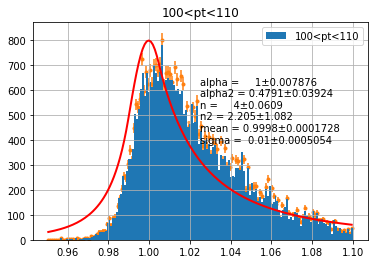

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.11136433354904116)


FCN = 298.7714835 
 TOTAL NCALL = 260 
 NCALLS = 249 
 
 
 EDM = 22.2402825536 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.89378,0.0861398,,,,,No
1,alpha2,0.26992,0.00694308,,,,,No
2,n,12.2298,3.11701,,,,,No
3,n2,108.916,36.0671,,,,,No
4,mean,1.00361,0.000262546,,,,,No
5,sigma,0.0104368,0.000219403,,,,,No


FCN = 298.7714835 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 20.1729153699 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.89378,0.0799765,,,,,No
1,alpha2,0.26992,0.00618197,,,,,No
2,n,12.2298,3.10657,,,,,No
3,n2,108.916,36.103,,,,,No
4,mean,1.00361,0.000237775,,,,,No
5,sigma,0.0104368,0.000193015,,,,,No


FCN = 298.7714835 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 20.1729153699 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.89378,0.0799765,,,,,No
1,alpha2,0.26992,0.00618197,,,,,No
2,n,12.2298,3.10657,,,,,No
3,n2,108.916,36.103,,,,,No
4,mean,1.00361,0.000237775,,,,,No
5,sigma,0.0104368,0.000193015,,,,,No


FCN = 298.7714835 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 20.1729153699 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.89378,0.0799765,,,,,No
1,alpha2,0.26992,0.00618197,,,,,No
2,n,12.2298,3.10657,,,,,No
3,n2,108.916,36.103,,,,,No
4,mean,1.00361,0.000237775,,,,,No
5,sigma,0.0104368,0.000193015,,,,,No


90<pt<100
21


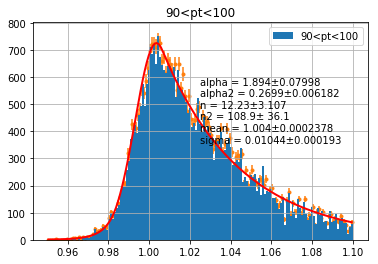

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.11698799095771396)


FCN = 391.737071156 
 TOTAL NCALL = 219 
 NCALLS = 208 
 
 
 EDM = 134.094056707 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.71178,0.0626615,,,,,No
1,alpha2,0.252865,0.00831788,,,,,No
2,n,5.51759,0.731866,,,,,No
3,n2,84.9645,44.4364,,,,,No
4,mean,1.00401,0.000306519,,,,,No
5,sigma,0.0104576,0.000297812,,,,,No


FCN = 333.908001147 
 TOTAL NCALL = 112 
 NCALLS = 101 
 
 
 EDM = 2.05764323053 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.07049,0.0688407,,,,,No
1,alpha2,0.319282,0.00820279,,,,,No
2,n,6.22065,0.659967,,,,,No
3,n2,99.5009,47.9825,,,,,No
4,mean,1.00707,0.00031105,,,,,No
5,sigma,0.0127634,0.000264302,,,,,No


FCN = 333.908001147 
 TOTAL NCALL = 89 
 NCALLS = 78 
 
 
 EDM = 4.95362830254 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.07049,0.0884408,,,,,No
1,alpha2,0.319282,0.0075361,,,,,No
2,n,6.22065,1.17398,,,,,No
3,n2,99.5009,52.2578,,,,,No
4,mean,1.00707,0.000276863,,,,,No
5,sigma,0.0127634,0.000221638,,,,,No


FCN = 333.908001147 
 TOTAL NCALL = 89 
 NCALLS = 78 
 
 
 EDM = 4.95362830254 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.07049,0.0884408,,,,,No
1,alpha2,0.319282,0.0075361,,,,,No
2,n,6.22065,1.17398,,,,,No
3,n2,99.5009,52.2578,,,,,No
4,mean,1.00707,0.000276863,,,,,No
5,sigma,0.0127634,0.000221638,,,,,No


80<pt<90
22


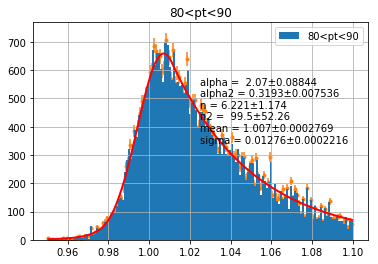

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.12309542776047293)


FCN = 381.921610476 
 TOTAL NCALL = 207 
 NCALLS = 196 
 
 
 EDM = 291.657306761 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.25306,0.707107,,,,,No
1,alpha2,0.218066,0.710357,,,,,No
2,n,6.80758,0.861913,,,,,No
3,n2,98.5907,52.7717,,,,,No
4,mean,1.00542,0.710425,,,,,No
5,sigma,0.0100422,0.710425,,,,,No


FCN = 360.951811078 
 TOTAL NCALL = 110 
 NCALLS = 99 
 
 
 EDM = 1950.27845876 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.39353,0.707107,,,,,No
1,alpha2,0.23559,0.714691,,,,,No
2,n,6.09151,0.796781,,,,,No
3,n2,92.8113,56.6075,,,,,No
4,mean,1.00589,0.714822,,,,,No
5,sigma,0.0108421,0.714822,,,,,No


FCN = 289.921724705 
 TOTAL NCALL = 153 
 NCALLS = 153 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.02812,nan,,,,,No
1,alpha2,0.315886,nan,,,,,No
2,n,7.25469,nan,,,,,No
3,n2,117.652,nan,,,,,No
4,mean,1.00856,nan,,,,,No
5,sigma,0.0138397,nan,,,,,No


FCN = 289.562922789 
 TOTAL NCALL = 187 
 NCALLS = 176 
 
 
 EDM = 0.0122640837728 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.03788,0.202388,,,,,No
1,alpha2,0.315416,0.0100571,,,,,No
2,n,8.19478,7.04436,,,,,No
3,n2,117.528,270.195,,,,,No
4,mean,1.00863,0.000327287,,,,,No
5,sigma,0.0138988,0.000273747,,,,,No


70<pt<80
23


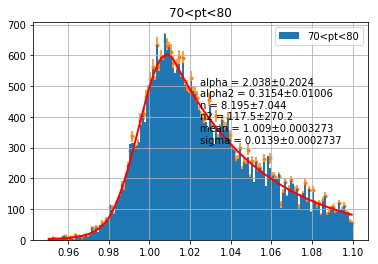

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.13111861459290391)


FCN = 267.793263221 
 TOTAL NCALL = 1225 
 NCALLS = 1214 
 
 
 EDM = 2.30682551998e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.92476,0.715667,,,,,No
1,alpha2,-0.290687,0.706226,,,,,No
2,n,5.59806,2.87857,,,,,No
3,n2,17.3968,5.44706,,,,,No
4,mean,1.00955,0.707107,,,,,No
5,sigma,0.0145201,0.0352925,,,,,No


FCN = 267.793263221 
 TOTAL NCALL = 101 
 NCALLS = 90 
 
 
 EDM = 426307.745143 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.92476,0.111728,,,,,No
1,alpha2,-0.290687,6.79437e-05,,,,,No
2,n,5.59806,2.6593,,,,,No
3,n2,17.3968,6.78361,,,,,No
4,mean,1.00955,0.000163793,,,,,No
5,sigma,0.0145201,0.000160477,,,,,No


FCN = 267.793263221 
 TOTAL NCALL = 101 
 NCALLS = 90 
 
 
 EDM = 426307.745143 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.92476,0.111728,,,,,No
1,alpha2,-0.290687,6.79437e-05,,,,,No
2,n,5.59806,2.6593,,,,,No
3,n2,17.3968,6.78361,,,,,No
4,mean,1.00955,0.000163793,,,,,No
5,sigma,0.0145201,0.000160477,,,,,No


FCN = 267.793263221 
 TOTAL NCALL = 101 
 NCALLS = 90 
 
 
 EDM = 426307.745143 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.92476,0.111728,,,,,No
1,alpha2,-0.290687,6.79437e-05,,,,,No
2,n,5.59806,2.6593,,,,,No
3,n2,17.3968,6.78361,,,,,No
4,mean,1.00955,0.000163793,,,,,No
5,sigma,0.0145201,0.000160477,,,,,No


60<pt<70
24


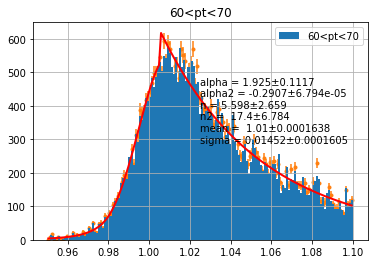

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.13646397366528185)


FCN = 291.196848494 
 TOTAL NCALL = 283 
 NCALLS = 272 
 
 
 EDM = 0.0354076207324 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.82344,0.0805049,,,,,No
1,alpha2,-0.27884,0.00778059,,,,,No
2,n,7.98896,2.59659,,,,,No
3,n2,111.753,83.1603,,,,,No
4,mean,1.01231,0.000381336,,,,,No
5,sigma,0.0160044,0.000326218,,,,,No


FCN = 291.196848494 
 TOTAL NCALL = 95 
 NCALLS = 84 
 
 
 EDM = 0.126932827161 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.82344,0.113238,,,,,No
1,alpha2,-0.27884,0.00732438,,,,,No
2,n,7.98896,5.11108,,,,,No
3,n2,111.753,111.267,,,,,No
4,mean,1.01231,0.000371636,,,,,No
5,sigma,0.0160044,0.000309091,,,,,No


FCN = 291.196848494 
 TOTAL NCALL = 95 
 NCALLS = 84 
 
 
 EDM = 0.126932827161 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.82344,0.113238,,,,,No
1,alpha2,-0.27884,0.00732438,,,,,No
2,n,7.98896,5.11108,,,,,No
3,n2,111.753,111.267,,,,,No
4,mean,1.01231,0.000371636,,,,,No
5,sigma,0.0160044,0.000309091,,,,,No


FCN = 291.196848494 
 TOTAL NCALL = 95 
 NCALLS = 84 
 
 
 EDM = 0.126932827161 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.82344,0.113238,,,,,No
1,alpha2,-0.27884,0.00732438,,,,,No
2,n,7.98896,5.11108,,,,,No
3,n2,111.753,111.267,,,,,No
4,mean,1.01231,0.000371636,,,,,No
5,sigma,0.0160044,0.000309091,,,,,No


50<pt<60
25


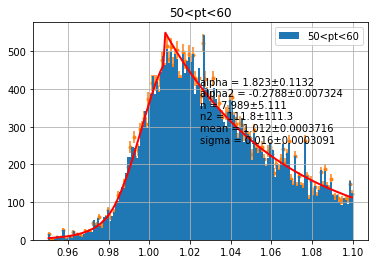

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.14236260405379678)


FCN = 238.854404761 
 TOTAL NCALL = 502 
 NCALLS = 491 
 
 
 EDM = 0.0315936558841 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.3887,0.0752702,,,,,No
1,alpha2,0.269213,0.0114591,,,,,No
2,n,133.333,165.214,,,,,No
3,n2,57.8598,40.4227,,,,,No
4,mean,1.01576,0.000566987,,,,,No
5,sigma,0.0177364,0.000552824,,,,,No


FCN = 238.545290482 
 TOTAL NCALL = 124 
 NCALLS = 113 
 
 
 EDM = 1.76632479559 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.3887,0.0745118,,,,,No
1,alpha2,0.269213,0.0197015,,,,,No
2,n,133.333,263.202,,,,,No
3,n2,22.8616,50.5953,,,,,No
4,mean,1.01576,0.000607916,,,,,No
5,sigma,0.0177364,0.000592704,,,,,No


FCN = 238.545290482 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 2.09589962048 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.3887,0.0681307,,,,,No
1,alpha2,0.269213,0.0204904,,,,,No
2,n,133.333,265.485,,,,,No
3,n2,22.8616,55.4064,,,,,No
4,mean,1.01576,0.000574205,,,,,No
5,sigma,0.0177364,0.000534959,,,,,No


FCN = 238.545290482 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 2.09589962048 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.3887,0.0681307,,,,,No
1,alpha2,0.269213,0.0204904,,,,,No
2,n,133.333,265.485,,,,,No
3,n2,22.8616,55.4064,,,,,No
4,mean,1.01576,0.000574205,,,,,No
5,sigma,0.0177364,0.000534959,,,,,No


40<pt<50
26


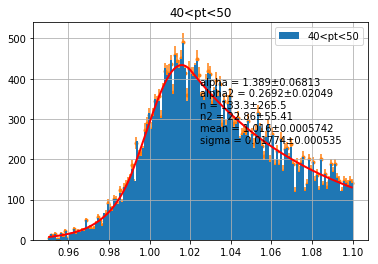

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.14478037135663974)


FCN = 273.900938968 
 TOTAL NCALL = 220 
 NCALLS = 220 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.635241,nan,,,,,No
1,alpha2,0.111116,nan,,,,,No
2,n,6.60616,nan,,,,,No
3,n2,103.433,nan,,,,,No
4,mean,1.01245,nan,,,,,No
5,sigma,0.00973648,nan,,,,,No


FCN = 273.900938968 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.635241,nan,,,,,No
1,alpha2,0.111116,nan,,,,,No
2,n,6.60616,nan,,,,,No
3,n2,103.433,nan,,,,,No
4,mean,1.01245,nan,,,,,No
5,sigma,0.00973648,nan,,,,,No


FCN = 273.900938968 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.635241,nan,,,,,No
1,alpha2,0.111116,nan,,,,,No
2,n,6.60616,nan,,,,,No
3,n2,103.433,nan,,,,,No
4,mean,1.01245,nan,,,,,No
5,sigma,0.00973648,nan,,,,,No


FCN = 273.900938968 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.635241,nan,,,,,No
1,alpha2,0.111116,nan,,,,,No
2,n,6.60616,nan,,,,,No
3,n2,103.433,nan,,,,,No
4,mean,1.01245,nan,,,,,No
5,sigma,0.00973648,nan,,,,,No


30<pt<40
27


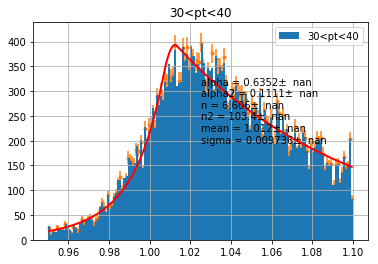

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 0.9998, -0.14345630885796504)


FCN = 471.18473337 
 TOTAL NCALL = 278 
 NCALLS = 267 
 
 
 EDM = 195.143398723 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.878704,0.0350626,,,,,No
1,alpha2,0.0390466,0.00363226,,,,,No
2,n,1.00408,0.040732,,,,,No
3,n2,48.4004,25.2632,,,,,No
4,mean,1.00785,0.000906601,,,,,No
5,sigma,0.00789668,0.000149644,,,,,No


FCN = 239.799408715 
 TOTAL NCALL = 148 
 NCALLS = 137 
 
 
 EDM = 12.5494369554 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.79113,0.149683,,,,,No
1,alpha2,0.217162,0.0190735,,,,,No
2,n,1.33858,0.0501425,,,,,No
3,n2,87.923,154.018,,,,,No
4,mean,1.02914,0.00182602,,,,,No
5,sigma,0.0291651,0.00264754,,,,,No


FCN = 227.475689581 
 TOTAL NCALL = 139 
 NCALLS = 128 
 
 
 EDM = 79.6641865951 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.77941,0.5803,,,,,No
1,alpha2,0.227851,0.00951788,,,,,No
2,n,1.07716,2.98917,,,,,No
3,n2,93.5398,99.1839,,,,,No
4,mean,1.02907,0.000500402,,,,,No
5,sigma,0.0291309,0.00116363,,,,,No


FCN = 224.498231094 
 TOTAL NCALL = 109 
 NCALLS = 98 
 
 
 EDM = 82.2136100994 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.77483,0.572952,,,,,No
1,alpha2,0.231066,0.0101658,,,,,No
2,n,1.05844,2.71845,,,,,No
3,n2,95.8753,106.646,,,,,No
4,mean,1.02903,0.000603062,,,,,No
5,sigma,0.029139,0.00139701,,,,,No


20<pt<30
28


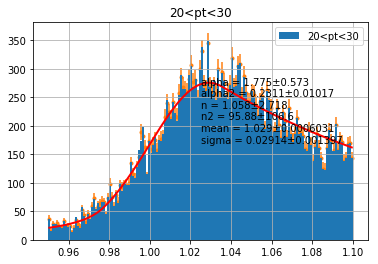

[0.99586147 0.99830798 0.99852944 0.99768229 0.9983855  0.9983824
 0.99905204 0.99856698 1.002      0.9989845  1.00039496 0.99944559
 1.00025195 1.00048181 1.00148563 1.00125524 1.0032747  1.00339046
 1.00384044 1.00435505 0.9998     1.00361467 1.0070724  1.00862945
 1.00955414 1.01230678 1.0157567  1.01245259 1.02903188]
[0.00850976 0.00785728 0.00771051 0.00740317 0.00771914 0.00763169
 0.00797304 0.00768047 0.01       0.0079246  0.00867733 0.00812773
 0.00851462 0.0088018  0.00930785 0.00927216 0.01061582 0.01079378
 0.010823   0.01127594 0.01       0.01043681 0.0127634  0.0138988
 0.01452009 0.01600436 0.01773644 0.00973648 0.02913903]


In [33]:
n=29
pt=np.zeros((n))
mean_pt=np.zeros((n))
err_mean_pt=np.zeros((n))
sigma_pt=np.zeros((n))
err_sigma_pt=np.zeros((n))

feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
i=0

for para in feat_pt:
    plt.figure()
    df=DF.query(para).astype('double')
  
    data=np.array(df.query('0.95<target<1.1')['target']).astype('double')
    nbins = 150
    out=plt.hist(data,bins=nbins,label=para,density=0)
    plt.title(para)
    
    
    plt.legend()
    
    rmin = 0.95
    rmax = 1.1
    df=DF.query(para).astype('double')
    
    bound_DCB=[rmin, rmax]
    normalized_DCB_pt = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood_pt = probfit.BinnedLH(normalized_DCB_pt, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(4):
        if j==0:
            if i==18:
                a=0.99
            if i<15:
                a=1.002
            elif i==0:
                a=1
            else:
                a=0.9998
            pars_dcb = dict(mean  =a , 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 4,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 20,
                        fix_n2  = False
        
                           )
        elif j==1:
            
              pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
        elif j==2:
            pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
        elif j==3:
            pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
        minuit_pt = iminuit.Minuit(binned_likelihood_pt,print_level=3, **pars_dcb)
        minuit_pt.migrad() #optimized parameter
        if j==2 and i!=18:
            j+=1
    binned_likelihood_pt.draw(minuit_pt,nfbins=nbins, parmloc=(0.5,0.75))
    
    print(para)
    mean_pt[i]=minuit_pt.values['mean']
    sigma_pt[i]=minuit_pt.values['sigma']
    err_mean_pt[i]=minuit_pt.errors['mean']
    err_sigma_pt[i]=minuit_pt.errors['sigma']
    print(i)
    i+=1
    plt.savefig('target_'+para+'_fit'+'_pt'+'.png')
    
    plt.show()
print(mean_pt)
print(sigma_pt)

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:56: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:56: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.0, -0.05466512900777128)


FCN = 4788.08384967 
 TOTAL NCALL = 170 
 NCALLS = 159 
 
 
 EDM = 234128.03768 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.00580731,,,,,No
1,alpha2,1,0.0464601,,,,,No
2,n,4,0.0430817,,,,,No
3,n2,2.35552,1.65941,,,,,No
4,mean,1,0.000145936,,,,,No
5,sigma,0.01,0.000381878,,,,,No


FCN = 4788.08384967 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 231037.6773 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.0057867,,,,,No
1,alpha2,1,0.049016,,,,,No
2,n,4,0.0437014,,,,,No
3,n2,2.35552,1.67995,,,,,No
4,mean,1,0.000149361,,,,,No
5,sigma,0.01,0.000365643,,,,,No


FCN = 4788.08384967 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 231037.6773 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1,0.0057867,,,,,No
1,alpha2,1,0.049016,,,,,No
2,n,4,0.0437014,,,,,No
3,n2,2.35552,1.67995,,,,,No
4,mean,1,0.000149361,,,,,No
5,sigma,0.01,0.000365643,,,,,No


220<pt<230
8


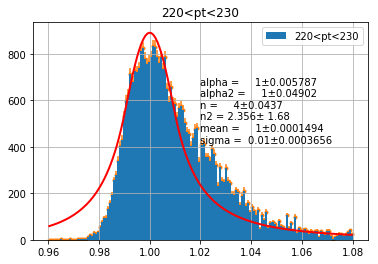

In [48]:
para='220<pt<230'
i=8
plt.figure()
    
df=DF.query(para).astype('double')
rmin = 0.96
rmax = 1.08
data=np.array(df.query('0.96<target<1.08')['target']).astype('double')
nbins = 150
out=plt.hist(data,bins=nbins,label=para,density=0,range=[rmin,rmax])
plt.title(para)
    
    
plt.legend()
    
rmin = 0.96
rmax = 1.08
df=DF.query(para).astype('double')
    
bound_DCB=[rmin, rmax]
normalized_DCB_pt = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood_pt = probfit.BinnedLH(normalized_DCB_pt, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(3):
    if j==0:
           
        pars_dcb = dict(mean  =1, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 4,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 20,
                        fix_n2  = False
        
                           )
    else:
        pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
    minuit_pt = iminuit.Minuit(binned_likelihood_pt,print_level=3, **pars_dcb)
    minuit_pt.migrad() #optimized parameter
print(para)
binned_likelihood_pt.draw(minuit_pt,nfbins=nbins, parmloc=(0.5,0.75))
mean_pt[i]=minuit_pt.values['mean']
sigma_pt[i]=minuit_pt.values['sigma']
err_mean_pt[i]=minuit_pt.errors['mean']
err_sigma_pt[i]=minuit_pt.errors['sigma']
print(i)
i+=1
plt.savefig('target_'+para+'_fit'+'_pt'+'.png')
    
plt.show()

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:55: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:55: SmallIntegralWarning: (1.0, 1.0, 4.0, 20.0, 1.0, -0.10264762187110325)


FCN = 346.940780781 
 TOTAL NCALL = 371 
 NCALLS = 360 
 
 
 EDM = 0.674496296821 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.34052,0.159191,,,,,No
1,alpha2,0.3124,0.00738666,,,,,No
2,n,15.2739,10.9213,,,,,No
3,n2,113.963,61.591,,,,,No
4,mean,1.00443,0.000257154,,,,,No
5,sigma,0.0109697,0.0001825,,,,,No


FCN = 346.940780781 
 TOTAL NCALL = 97 
 NCALLS = 86 
 
 
 EDM = 0.669596958804 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.34052,0.155499,,,,,No
1,alpha2,0.3124,0.00676665,,,,,No
2,n,15.2739,10.909,,,,,No
3,n2,113.963,61.6592,,,,,No
4,mean,1.00443,0.00023622,,,,,No
5,sigma,0.0109697,0.000165589,,,,,No


FCN = 346.940780781 
 TOTAL NCALL = 97 
 NCALLS = 86 
 
 
 EDM = 0.669596958804 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,2.34052,0.155499,,,,,No
1,alpha2,0.3124,0.00676665,,,,,No
2,n,15.2739,10.909,,,,,No
3,n2,113.963,61.6592,,,,,No
4,mean,1.00443,0.00023622,,,,,No
5,sigma,0.0109697,0.000165589,,,,,No


100<pt<110
20


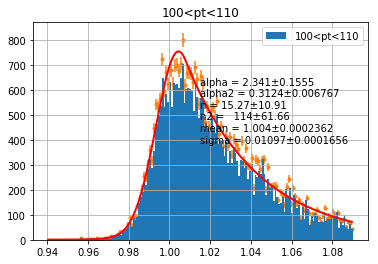

In [37]:
para='100<pt<110'
i=20
plt.figure()
    
df=DF.query(para).astype('double')
  
data=np.array(df.query('0.94<target<1.09')['target']).astype('double')
nbins = 150
out=plt.hist(data,bins=nbins,label=para,density=0)
plt.title(para)
    
    
plt.legend()
    
rmin = 0.94
rmax = 1.09
df=DF.query(para).astype('double')
    
bound_DCB=[rmin, rmax]
normalized_DCB_pt = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood_pt = probfit.BinnedLH(normalized_DCB_pt, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(3):
    if j==0:
           
        pars_dcb = dict(mean  =1, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 4,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 20,
                        fix_n2  = False
        
                           )
    else:
        pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
    minuit_pt = iminuit.Minuit(binned_likelihood_pt,print_level=3, **pars_dcb)
    minuit_pt.migrad() #optimized parameter
print(para)
binned_likelihood_pt.draw(minuit_pt,nfbins=nbins, parmloc=(0.5,0.75))
''''mean_pt[i]=minuit_pt.values['mean']
sigma_pt[i]=minuit_pt.values['sigma']
err_mean_pt[i]=minuit_pt.errors['mean']
err_sigma_pt[i]=minuit_pt.errors['sigma']'''
print(i)
i+=1
plt.savefig('target_'+para+'_fit'+'_pt'+'.png')
    
plt.show()

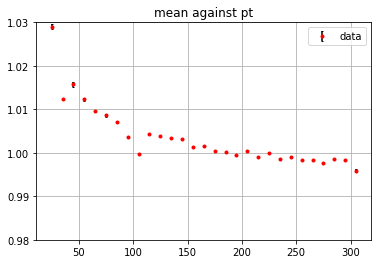

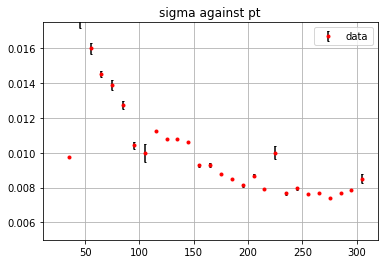

In [36]:
   
X=np.atleast_2d(pt).T
y=mean_pt
x = np.atleast_2d(np.linspace(20, 320, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sig = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()

plt.errorbar(pt,mean_pt, yerr=err_mean_pt, fmt='r.',label='data',ecolor='black',capsize=1)
#plt.plot(x, y_pred, 'b-', label=u'Prediction')
#plt.fill(np.concatenate([x, x[::-1]]),
 #        np.concatenate([y_pred - 1.9600 * sig,
 #                       (y_pred + 1.9600 * sig)[::-1]]),
   #      alpha=.5, fc='b', ec='None', label='95% confidence interval')
   

plt.title('mean against pt')
#plt.xlabel('$\eta$')
plt.legend()

plt.grid()
plt.ylim(0.98,1.03)
plt.savefig('mean_against_pt'+'.png')
plt.show()

Xs=np.atleast_2d(pt).T
ys=sigma_pt
x = np.atleast_2d(np.linspace(20, 300, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters

gp.fit(Xs, ys)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sig= gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()

plt.errorbar(pt,sigma_pt,yerr=err_sigma_pt,fmt='r.',label='data',ecolor='black',capsize=1)
#plt.plot(x, y_pred, 'b-', label=u'Prediction')
#plt.fill(np.concatenate([x, x[::-1]]),
         #np.concatenate([y_pred - 1.9600 * sig,
         #               (y_pred + 1.9600 * sig)[::-1]]),
         #alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.ylim(0.005,0.0175)

#plt.ylabel('$\sigma$')
plt.title('sigma against pt')
plt.savefig('sigma_against_pt'+'.png')
plt.grid()
plt.legend()
plt.show()